In [65]:
# ==========================================
# ⚡ GPU + XLA acceleration (added at top)
# ==========================================
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"   # Enable XLA fusion
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"             # suppress TF INFO/WARN
os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"            # suppress verbose C++ logs

import logging, absl.logging
import tensorflow as tf

# 🔧 Threading config MUST be set before TF runtime initializes
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

# Logging levels
tf.get_logger().setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# XLA JIT
tf.config.optimizer.set_jit(True)                    # Just-In-Time compile

# Enable full GPU memory and multi-GPU graph
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ {len(gpus)} GPU(s) active, memory growth enabled.")
else:
    print("ℹ️ CPU mode.")

tf.debugging.set_log_device_placement(False)



# =========================
# Cell 1 — Setup & Splits
# =========================
import os

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 2=warnings+errors, 3=errors only
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"

import json, random
import numpy as np
import h5py
import joblib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import logging
import absl.logging
tf.get_logger().setLevel('ERROR')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)



# --- Quiet TF a bit ---
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# # --- GPU: enable memory growth if present (safe no-op on CPU) ---
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     try:
#         for g in gpus:
#             tf.config.experimental.set_memory_growth(g, True)
#         print(f"✅ GPUs: {len(gpus)} | Memory growth enabled")
#     except Exception as e:
#         print("⚠️ GPU setup issue:", e)
# else:
#     print("ℹ️ No GPU detected (CPU mode)")

# --- Paths ---
DATA_DIR = os.getenv("PBROM_DATA_DIR", "PBROM data")  # change if your folder name differs
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("scalers", exist_ok=True)
os.makedirs("ablation", exist_ok=True)
os.makedirs("figs", exist_ok=True)

# # --- ⭐️ MODIFIED: File lists are now grouped ⭐️ ---
# This is now the "single source of truth" for all files.
# Based on your request for granular, per-cell groups.


# TRAIN_GROUPS = {
#     "PBROM_Cells_1": [
#         "PBROM_data_cell_24.mat",
#     ],
#     "PBROM_Cells_2": [
#         "PBROM_data_cell_32.mat",
#     ],
#     "NASA_Cells_1": [
#         "PBROM_data_NASA_B7.mat",
#     ],
#     "NASA_Cells_2": [
#         "PBROM_data_NASA_B30.mat",
#     ],
#     "D5_Cells_1": [
#         "PBROM_data_cell_D5C77.mat",
#     ]
# }

# VAL_GROUPS = {
#     "PBROM_Cells_1_Val": [
#         "PBROM_data_cell_26.mat",
#     ],
#     "PBROM_Cells_2_Val": [
#         "PBROM_data_cell_33.mat",
#     ],
#     "NASA_Cells_1_Val": [
#         "PBROM_data_NASA_B6.mat",
#     ],
#     "NASA_Cells_2_Val": [
#         "PBROM_data_NASA_B29.mat",
#     ],
#     "D5_Cells_1_Val": [
#         "PBROM_data_cell_D5C69.mat",
#     ]
# }

# TEST_GROUPS = {
#     "PBROM_Cells_1_Test": [
#         "PBROM_data_cell_28.mat",
#     ],
#     "PBROM_Cells_2_Test": [
#         "PBROM_data_cell_35.mat",
#     ],
#     "NASA_Cells_1_Test": [
#         "PBROM_data_NASA_B5.mat",
#     ],
#     "NASA_Cells_2_Test": [
#         "PBROM_data_NASA_B32.mat",
#     ],
#     "D5_Cells_1_Test": [
#         "PBROM_data_cell_D5C78.mat",
#     ]
# }




# TRAIN_GROUPS = {
#     "PBROM_Cells_2": [
#         "PBROM_data_cell_32.mat",
#     ],
#     "NASA_Cells_2": [
#         "PBROM_data_NASA_B30.mat",
#     ]
# }

# VAL_GROUPS = {
#     "PBROM_Cells_2_Val": [
#         "PBROM_data_cell_33.mat",
#     ],
#     "NASA_Cells_2_Val": [
#         "PBROM_data_NASA_B29.mat",
#     ]
# }

# TEST_GROUPS = {
#     "PBROM_Cells_2_Test": [
#         "PBROM_data_cell_35.mat",
#     ],
#     "NASA_Cells_2_Test": [
#         "PBROM_data_NASA_B32.mat",
#     ]
# }



TRAIN_GROUPS = {
    "PBROM_Cells_1": [
        "PBROM_data_cell_24.mat",
    ],
    "D5_Cells_1": [
        "PBROM_data_cell_D5C77.mat",
    ]
}

VAL_GROUPS = {
    "PBROM_Cells_1_Val": [
        "PBROM_data_cell_26.mat",
    ],
    "D5_Cells_1_Val": [
        "PBROM_data_cell_D5C69.mat",
    ]
}

TEST_GROUPS = {
    "PBROM_Cells_1_Test": [
        "PBROM_data_cell_28.mat",
    ],
    "D5_Cells_1_Test": [
        "PBROM_data_cell_D5C78.mat",
    ]
}

# --- ⭐️ NEW: Auto-generate flat lists and lookup map ⭐️ ---
# (This code builds all the helper lists we need)

TRAIN_FILES = [f for files in TRAIN_GROUPS.values() for f in files]
VAL_FILES = [f for files in VAL_GROUPS.values() for f in files]
TEST_FILES = [f for files in TEST_GROUPS.values() for f in files]

# This is our critical "lookup map"
# It maps every single file to a group name, which we use to load the correct scaler
FILE_TO_GROUP_MAP = {}
all_groups = {**TRAIN_GROUPS, **VAL_GROUPS, **TEST_GROUPS}
for group, files in all_groups.items():
    for f in files:
        # We find the "base" name for the scaler (e.g., "PBROM_Cells_1")
        # This allows "PBROM_Cells_1_Val" to use the "PBROM_Cells_1" scaler
        base_group = group.split('_Val')[0].split('_Test')[0]
        FILE_TO_GROUP_MAP[f] = base_group

print(f"✅ File map generated: {len(FILE_TO_GROUP_MAP)} files mapped to base groups.")
print(f"  Example lookup: {TRAIN_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TRAIN_FILES[0])}")
print(f"  Example lookup: {VAL_FILES[0]} -> {FILE_TO_GROUP_MAP.get(VAL_FILES[0])}")
print(f"  Example lookup: {TEST_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TEST_FILES[0])}")
# -----------------------------------------------------------


# --- Helper: robust HDF5 .mat loader (squeezes to 1D/2D np arrays) ---
def _read_field(f, key, required=True):
    if key not in f:
        if required:
            raise KeyError(f"Missing key '{key}' in MAT file.")
        return None
    arr = np.array(f[key])
    # MATLAB often stores column vectors as (1, N) or (N, 1); squeeze safely
    return np.squeeze(arr)

def load_mat(file_name):
    """
    Loads a PBROM/NASA cell .mat file and returns a dict of numpy arrays:
      I_p, SOC_p, Time_s_p, Q_exp_p, Q_total_p, V_cum_p, Temp_cum_p,
      C_rate_profile, Bat_cap_profile, R_ch_profile, V_max_profile, V_min_profile,
      Cap_Nom, t_exp
    """
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Couldn't find: {path}")
    with h5py.File(path, "r") as f:
        data = {
            "I_p":                 _read_field(f, "I_p"),
            "SOC_p":               _read_field(f, "SOC_p"),
            "Time_s_p":            _read_field(f, "Time_s_p"),
            "Q_exp_p":             _read_field(f, "Q_exp_p"),
            "Q_total_p":           _read_field(f, "Q_total_p"),
            "V_cum_p":             _read_field(f, "V_cum_p"),
            "Temp_cum_p":          _read_field(f, "Temp_cum_p"),
            "C_rate_profile":      _read_field(f, "C_rate_profile"),
            "Bat_cap_profile":     _read_field(f, "Bat_cap_profile"),
            "R_ch_profile":        _read_field(f, "R_ch_profile"),
            "V_max_profile":       _read_field(f, "V_max_profile"),
            "V_min_profile":       _read_field(f, "V_min_profile"),
            "Cap_Nom":             _read_field(f, "Cap_Nom"),
            "t_exp":               _read_field(f, "t_exp"),
        }
    return data

# --- Quick sanity: print counts and peek sizes if files exist ---
def _peek(files, tag):
    ok = 0
    for fn in files:
        try:
            d = load_mat(fn)
            n = len(np.atleast_1d(d["Time_s_p"]))
            print(f"[{tag}] {fn}: N={n}")
            ok += 1
        except Exception as e:
            print(f"[{tag}] {fn}: ({e})")
    print(f"[{tag}] Found/loaded {ok}/{len(files)} files in '{DATA_DIR}'")

print("\nVerifying file availability (optional):")
# _peek now uses the new auto-generated flat lists
_peek(TRAIN_FILES, "TRAIN")
_peek(VAL_FILES,   "VAL")
_peek(TEST_FILES,  "TEST")

# =========================
# ADD TO END OF CELL 1
# =========================

# Get all unique "base" group names from the file map
# This ensures all groups (train, val, test) are included
ALL_BASE_GROUPS = sorted(list(set(FILE_TO_GROUP_MAP.values())))

# Create the ID mapping
GROUP_TO_ID_MAP = {group_name: i for i, group_name in enumerate(ALL_BASE_GROUPS)}
NUM_GROUPS = len(ALL_BASE_GROUPS)

print(f"\n✅ Group ID map generated ({NUM_GROUPS} total groups):")
for group_name, idx in GROUP_TO_ID_MAP.items():
    print(f"  {idx}: {group_name}")

# This map will now be available to all other cells

print("\n✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.")

✅ 1 GPU(s) active, memory growth enabled.
✅ File map generated: 6 files mapped to base groups.
  Example lookup: PBROM_data_cell_24.mat -> PBROM_Cells_1
  Example lookup: PBROM_data_cell_26.mat -> PBROM_Cells_1
  Example lookup: PBROM_data_cell_28.mat -> PBROM_Cells_1

Verifying file availability (optional):
[TRAIN] PBROM_data_cell_24.mat: N=150863
[TRAIN] PBROM_data_cell_D5C77.mat: N=1200000
[TRAIN] Found/loaded 2/2 files in 'PBROM data'
[VAL] PBROM_data_cell_26.mat: N=151439
[VAL] PBROM_data_cell_D5C69.mat: N=1200000
[VAL] Found/loaded 2/2 files in 'PBROM data'
[TEST] PBROM_data_cell_28.mat: N=151631
[TEST] PBROM_data_cell_D5C78.mat: N=1200000
[TEST] Found/loaded 2/2 files in 'PBROM data'

✅ Group ID map generated (2 total groups):
  0: D5_Cells_1
  1: PBROM_Cells_1

✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.


In [66]:
# ==========================================================
# Cell 2 — Pass-0 (v5 - FULL PER-GROUP Time & Feature Scaling)
# ==========================================================
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib
import os
import h5py

# ---- Constants ----
SCALE_DELTA = 1e5
T_MIN = 10.0
T_MAX = 50.0

# ---- PercentileScaler ----
class PercentileScaler:
    def __init__(self, p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20):
        self.p_scale = p_scale; self.p_clip = p_clip; self.eps = eps; self.min_pos = min_pos
        self.scale_ = 1.0; self.clip_limit_ = 1e9 
    def fit(self, x):
        x = np.asarray(x).reshape(-1); x_pos = x[x > 0] 
        if x_pos.size < self.min_pos:
            if x.size > 0:
                p_scale_val = np.percentile(x, max(self.p_scale, 99))
                p_clip_val = np.percentile(x, max(self.p_clip, 99.9))
            else:
                p_scale_val = 1.0; p_clip_val = 1.0
        else:
            p_scale_val = np.percentile(x_pos, self.p_scale)
            p_clip_val = np.percentile(x_pos, self.p_clip)
        self.scale_ = max(float(p_scale_val), self.eps)
        self.clip_limit_ = max(float(p_clip_val) / self.scale_, 1.0) 
    def transform(self, x):
        x_scaled = np.asarray(x).reshape(-1, 1) / self.scale_
        return np.clip(x_scaled, 0.0, self.clip_limit_)
    def inverse_transform(self, x): return np.asarray(x).reshape(-1, 1) * self.scale_

# ---- Helpers ----
def _grab_scalar(x, default=0.0):
    arr = np.asarray(x).reshape(-1)
    return float(arr[0]) if arr.size else default

def _read_field(f, key, required=True):
    if key not in f:
        if required: raise KeyError(f"Missing key '{key}' in MAT file.")
        return None
    return np.squeeze(np.array(f[key]))

def load_mat(file_name):
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path): raise FileNotFoundError(f"Couldn't find: {path}")
    with h5py.File(path, "r") as f:
        data = {
            "SOC_p": _read_field(f, "SOC_p"), "Time_s_p": _read_field(f, "Time_s_p"),
            "Q_exp_p": _read_field(f, "Q_exp_p"), "Q_total_p": _read_field(f, "Q_total_p"),
            "V_cum_p": _read_field(f, "V_cum_p"), "Temp_cum_p": _read_field(f, "Temp_cum_p"),
            "C_rate_profile": _read_field(f, "C_rate_profile"),
            "Bat_cap_profile": _read_field(f, "Bat_cap_profile"), "R_ch_profile": _read_field(f, "R_ch_profile"),
            "V_max_profile": _read_field(f, "V_max_profile"), "V_min_profile": _read_field(f, "V_min_profile"),
            "Cap_Nom": _read_field(f, "Cap_Nom"), "t_exp": _read_field(f, "t_exp"),
        }
    return data

# --- Compute Time Percentiles PER GROUP ---
def compute_group_time_percentiles(file_list):
    elapsed_pool = []
    dt_pool = []
    for fn in file_list:
        try:
            d = load_mat(fn)
            t = d["Time_s_p"].astype(np.float64).flatten()
            if t.size == 0: continue
            elapsed = t - t[0]
            dt = np.diff(t, prepend=t[0])
            elapsed_pool.append(elapsed)
            if dt.size > 1: dt_pool.append(dt[1:])
        except Exception as e: print(f"Skipping {fn} in time calc: {e}")
    
    elapsed_all = np.concatenate(elapsed_pool) if elapsed_pool else np.array([1.0])
    dt_all = np.concatenate(dt_pool) if dt_pool else np.array([1.0])
    
    p95_t = float(np.percentile(elapsed_all, 95))
    p95_dt = float(np.percentile(dt_all, 95))
    return p95_t, p95_dt

# --- Sample Rows (Takes specific p95_t) ---
def sample_dynamic_rows_for_scaler(file_list, p95_t, p95_dt):
    target_rows_total = 500_000
    per_file_target = max(10_000, target_rows_total // max(1, len(file_list)))
    rows = []
    for fn in file_list:
        try:
            d = load_mat(fn)
            SOC = np.atleast_1d(d["SOC_p"]).astype(np.float64).flatten()
            V   = np.atleast_1d(d["V_cum_p"]).astype(np.float64).flatten()
            T   = np.atleast_1d(d["Temp_cum_p"]).astype(np.float64).flatten()
            t   = np.atleast_1d(d["Time_s_p"]).astype(np.float64).flatten()
            Cr = np.atleast_1d(d["C_rate_profile"]).astype(np.float64).flatten()

            V_max = _grab_scalar(d["V_max_profile"], 4.2); V_min = _grab_scalar(d["V_min_profile"], 2.5)

            if t.size == 0: continue
            elapsed = t - t[0]; dt = np.diff(t, prepend=t[0])
            
            # ⭐️ Use Group-Specific P95 Time here
            t_abs_norm = np.clip(elapsed / max(p95_t, 1e-12), 0.0, 4.0)
            dt_norm    = np.clip(dt      / max(p95_dt, 1e-12), 0.0, 4.0)
            V_norm = np.clip((V - V_min) / max(V_max - V_min, 1e-6), -1.0, 2.0)
            T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

            N = min(SOC.size, V_norm.size, T_norm.size, t_abs_norm.size, dt_norm.size, Cr.size)
            if N <= 0: continue
            if N <= per_file_target: idx = np.arange(N)
            else: idx = np.linspace(0, N - 1, per_file_target).astype(int)

            dyn = np.stack([ SOC[idx], V_norm[idx], T_norm[idx], t_abs_norm[idx], dt_norm[idx], Cr[idx] ], axis=1)
            rows.append(dyn)
        except: pass
        
    if not rows: return np.zeros((10, 6), dtype=np.float64)
    return np.vstack(rows)

def collect_positive_deltas_scaled(file_list):
    buf = []
    for fn in file_list:
        try:
            d = load_mat(fn)
            Qe_norm = np.atleast_1d(d["Q_exp_p"]).astype(np.float64).flatten()
            Qp_norm = np.atleast_1d(d["Q_total_p"]).astype(np.float64).flatten()
            if Qe_norm.size < 2 or Qp_norm.size < 2: continue
            dq_e = np.maximum(Qe_norm[1:] - Qe_norm[:-1], 0.0) * SCALE_DELTA
            dq_p = np.maximum(Qp_norm[1:] - Qp_norm[:-1], 0.0) * SCALE_DELTA
            if dq_e.size: buf.append(dq_e)
            if dq_p.size: buf.append(dq_p)
        except: pass
    if not buf: return np.array([1.0])
    return np.concatenate(buf)

# ---- Execution ----
print("\n[Pass-0] Processing PER-GROUP Stats (Time, Features, Targets) ...")
feature_scalers = {}

for group_name, file_list in TRAIN_GROUPS.items():
    if not file_list: continue
    print(f"--- Group: {group_name} ---")

    # 1. Compute and Save Time Stats PER GROUP
    p95_t, p95_dt = compute_group_time_percentiles(file_list)
    time_stats_group = {"p95_t": p95_t, "p95_dt": p95_dt}
    
    ts_path = os.path.join("scalers", f"time_stats_{group_name}.json")
    with open(ts_path, "w") as f: json.dump(time_stats_group, f, indent=2)
    print(f"  ✓ Time stats: p95_t={p95_t:.2e}, p95_dt={p95_dt:.2f}")

    # 2. Fit Feature Scaler (using Group Time)
    dyn_rows_group = sample_dynamic_rows_for_scaler(file_list, p95_t, p95_dt)
    f_scaler = MinMaxScaler(feature_range=(0, 1))
    f_scaler.fit(dyn_rows_group)
    
    fs_path = os.path.join("scalers", f"feature_scaler_{group_name}.pkl")
    joblib.dump(f_scaler, fs_path)
    print(f"  ✓ Feature scaler saved")

    # 3. Fit Delta Scaler
    dq_group = collect_positive_deltas_scaled(file_list)
    delta_scaler_group = PercentileScaler(p_scale=95, p_clip=99.9)
    delta_scaler_group.fit(dq_group)
    
    ds_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
    joblib.dump(delta_scaler_group, ds_path)
    print(f"  ✓ Delta scaler saved")

# Static scaler remains global
def collect_static_rows(train_files):
    rows = []
    for fn in train_files:
        try:
            d = load_mat(fn)
            rows.append([ _grab_scalar(d["Bat_cap_profile"]), _grab_scalar(d["R_ch_profile"]), _grab_scalar(d["V_max_profile"]), _grab_scalar(d["V_min_profile"]) ])
        except: pass
    return np.array(rows, dtype=np.float64) if rows else np.zeros((1,4), dtype=np.float64)

print("\n[Pass-0] Fitting *global* static scaler ...")
static_rows = collect_static_rows(TRAIN_FILES)
static_scaler = StandardScaler()
static_scaler.fit(static_rows)
joblib.dump(static_scaler, os.path.join("scalers", "static_scaler.pkl"))
print("✅ Cell 2 complete: All per-group stats ready.")


[Pass-0] Processing PER-GROUP Stats (Time, Features, Targets) ...
--- Group: PBROM_Cells_1 ---
  ✓ Time stats: p95_t=1.15e+07, p95_dt=200.00
  ✓ Feature scaler saved
  ✓ Delta scaler saved
--- Group: D5_Cells_1 ---
  ✓ Time stats: p95_t=1.24e+07, p95_dt=99.02
  ✓ Feature scaler saved
  ✓ Delta scaler saved

[Pass-0] Fitting *global* static scaler ...
✅ Cell 2 complete: All per-group stats ready.


In [68]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


# ======================================
# Cell 3 — Main Hyperparameters (central)
# ======================================

# --- Windowing / dataset ---
WINDOW_SIZE = 80    # using 25-step window
STRIDE      = 1
BATCH_SIZE  = 768   # (legacy; training actually uses BATCH_PER_DEVICE)

# --- ⭐️ MODIFIED: Simplified Architecture ---
EMBED_DIM       = 128    # Reduced from 64
NUM_HEADS       = 4
FF_DIM          = 64    # Reduced from 128
NUM_LAYERS      = 4     # Reduced from 2
SOFTPLUS_BETA   = 1.0
GROUP_EMBED_DIM = 8

# --- Regularization (Keep these) ---
DROPOUT         = 0.20
L2_REG          = 5e-4
GAUSSIAN_NOISE_STDDEV = 0.001

# --- Training / optimization ---
BATCH_PER_DEVICE = 768  # effective batch size per GPU
EPOCHS           = 50   # you rarely need 50 with early stopping
LR               = 2.140965e-6 # same stable LR that worked well for you
CLIPNORM         = 1.0
AMSGRAD          = True

# --- Loss weights ---
LAMBDA_DATA = 1.0
LAMBDA_PHYS = 1.030679
LAMBDA_ZERO = 0.0
HUBER_DELTA = 1.0 

# --- Scheduler / early stopping ---
VAL_FREQ            = 2   # validate more often to catch best epoch
EARLY_STOP_PATIENCE = 5   # 5×2=10 epochs of no improvement allowed
LR_PATIENCE         = 3
LR_FACTOR           = 0.5
LR_MIN              = 1e-6

# --- Constants ---
SCALE_DELTA = 1e5

print("✅ Hyperparameters registered.")
print(f"✅ ARCHITECTURE: {NUM_LAYERS} Layers, {EMBED_DIM} Embed Dim")
print(f"✅ REGULARIZATION: DROPOUT={DROPOUT}, L2_REG={L2_REG}, NOISE_STDDEV={GAUSSIAN_NOISE_STDDEV}")

✅ Hyperparameters registered.
✅ ARCHITECTURE: 4 Layers, 128 Embed Dim
✅ REGULARIZATION: DROPOUT=0.2, L2_REG=0.0005, NOISE_STDDEV=0.001


In [69]:
# ==========================================================
# Cell 4 — Model Builder (v8 - "Concat Conditioning")
# ==========================================================
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Concatenate, TimeDistributed, Embedding, Lambda,
    Flatten, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# (transformer_encoder_prenorm is unchanged)
def transformer_encoder_prenorm(x, head_size, num_heads, ff_dim, dropout, l2_reg):
    x_ln1 = LayerNormalization(epsilon=1e-6)(x)
    attn  = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x_ln1, x_ln1)
    attn  = Dropout(dropout)(attn)
    x     = Add()([x, attn])
    
    x_ln2 = LayerNormalization(epsilon=1e-6)(x)
    ff    = Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x_ln2)
    ff    = Dropout(dropout)(ff)
    ff    = Dense(x.shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ff)
    x     = Add()([x, ff])
    return x

# (SharedPositionalEncoding is unchanged)
class SharedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super().__init__(**kwargs); self.window_size = int(window_size); self.embedding_dim = int(embedding_dim)
        self.embedding_layer = Embedding(input_dim=self.window_size, output_dim=self.embedding_dim, name="shared_pos_embedding")
    def call(self, x):
        T = tf.shape(x)[1]; positions = tf.range(start=0, limit=T, delta=1); pos_enc = self.embedding_layer(positions)
        pos_enc = tf.expand_dims(pos_enc, axis=0); pos_enc = tf.tile(pos_enc, [tf.shape(x)[0], 1, 1]); return x + pos_enc
    def get_config(self):
        cfg = super().get_config(); cfg.update({"window_size": self.window_size, "embedding_dim": self.embedding_dim}); return cfg

# ---- Model builder (v8 - Concat Conditioning) ----
def build_pitm_model(
    window_size,
    num_groups,                  # From Cell 1
    group_embed_dim=GROUP_EMBED_DIM, # From Cell 3
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    l2_reg=L2_REG,
    noise_stddev=GAUSSIAN_NOISE_STDDEV # From Cell 3
):
    """
    v8: Uses Concatenation for Group ID instead of Addition.
    This prevents LayerNorm from washing out the group signal.
    """
    head_size = max(1, embed_dim // num_heads)

    # ----- 1. Define Inputs -----
    dyn_in = Input(shape=(window_size, 7), name="dyn_in") # 7 features (incl. extra)
    stat_in = Input(shape=(4,), name="static_in")
    group_id_in = Input(shape=(1,), name="group_id_in", dtype='int32') 

    # ----- 2. Data Augmentation (Noise) -----
    dyn_noised = GaussianNoise(noise_stddev)(dyn_in)

    # ----- 3. Static Physics Processing -----
    stat_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1), name="expand_static")(stat_in) 
    stat_tiled = Lambda(lambda x: tf.tile(x[0], [1, window_size, 1]), name="tile_static")([stat_expanded, dyn_noised]) 

    # ----- 4. Group Embedding & Tiling -----
    group_vec = Embedding(
        input_dim=num_groups, 
        output_dim=group_embed_dim, 
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="group_embedding"
    )(group_id_in) # Shape: (Batch, 1, 8)

    group_vec_tiled = Lambda(lambda x: tf.tile(x, [1, window_size, 1]), name="tile_group")(group_vec)

    # ----- 5. ⭐️ CONCATENATION (The Fix) ⭐️ -----
    # Instead of adding, we stack them channel-wise.
    # Dynamic(7) + Static(4) + Group(8) = 19 channels
    dyn_combined = Concatenate(name="concat_all_features")([dyn_noised, stat_tiled, group_vec_tiled])
    
    # Project everything to the Transformer dimension
    x = TimeDistributed(
        Dense(embed_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)), 
        name="input_projection"
    )(dyn_combined)
    
    # ----- 6. Shared Body (Transformer) -----
    shared_pos = SharedPositionalEncoding(window_size, embed_dim, name="shared_pos_enc")
    x = shared_pos(x) 
    for _ in range(num_layers):
        x = transformer_encoder_prenorm(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, l2_reg=l2_reg)
    
    # Take last token
    take_last = Lambda(lambda t: t[:, -1, :], name="take_last_token")
    x_last = take_last(x)
    
    # ----- 7. ⭐️ Output Head Conditioning ⭐️ -----
    # Concatenate the Group ID *again* so the final regressor definitely knows which group it is
    group_vec_flat = Flatten(name="flatten_group")(group_vec)
    fused = Concatenate(name="concat_head")([x_last, group_vec_flat])
    
    fused_head = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(fused)
    fused_head = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(fused_head)
    
    raw = Dense(
        1,
        name="raw_pre_softplus",
        bias_initializer=initializers.Constant(0.0),
        kernel_regularizer=regularizers.l2(l2_reg),
    )(fused_head)

    # --- 8. Final Activation ---
    def softplus32(z, beta=1.0):
        z32 = tf.cast(z, tf.float32)
        out32 = tf.nn.softplus(beta * z32) / beta
        return tf.cast(out32, z.dtype)
    
    delta_hat = Lambda(lambda z: softplus32(z, beta=SOFTPLUS_BETA),
                       name="delta_hat")(raw)

    model = Model(
        inputs=[dyn_in, stat_in, group_id_in], 
        outputs=delta_hat,
        name="PITM_v8_Concat_Conditioning"
    )
    return model

# (Loss function is unchanged)
def pitm_delta_loss(lambda_data=1.0, lambda_phys=1.0, lambda_zero=0.0, huber_delta=1.5):
    def huber(e, delta): a = tf.abs(e); return tf.where(a <= delta, 0.5 * tf.square(e), delta * (a - 0.5 * delta))
    def _loss(y_true, y_pred):
        dq_exp = y_true[:, 0:1]; dq_pb = y_true[:, 1:2]; dq_hat = y_pred
        pos_mask = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32); zero_mask = 1.0 - pos_mask
        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta)); l_phys = tf.reduce_mean(huber(dq_pb - dq_hat, huber_delta))
        l_zero = tf.reduce_mean(zero_mask * dq_hat)
        return lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero
    return _loss

print("Building model with v8 'Concat Conditioning' architecture:")
model = build_pitm_model(
    window_size=WINDOW_SIZE,
    num_groups=NUM_GROUPS,  # From Cell 1
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
model.summary(line_length=120)
print("\n✅ Cell 4 ready: v8 'Concat' model built (uncompiled).")

Building model with v8 'Concat Conditioning' architecture:
Model: "PITM_v8_Concat_Conditioning"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 dyn_in (InputLayer)                   [(None, 80, 7)]            0             []                                      
                                                                                                                        
 static_in (InputLayer)                [(None, 4)]                0             []                                      
                                                                                                                        
 group_id_in (InputLayer)              [(None, 1)]                0             []                                      
                                                         

In [70]:
# ===============================================
# Cell 4.5 — Pre-process (v8.2 - Fixed Weighting)
# ===============================================
import numpy as np
import joblib
from tqdm import tqdm
import random
import json
import os
import h5py

# --- Local Helpers ---
def _read_field_local(f, key):
    if key not in f: return None
    return np.squeeze(np.array(f[key]))

def _grab1_local(x): 
    if x is None: return 0.0
    return float(np.asarray(x).reshape(-1)[0])

def _make_time_channels_local(Time_s, p95_t_in, p95_dt_in):
    t = np.asarray(Time_s, np.float64).flatten()
    elapsed = t - t[0]
    dt = np.diff(t, prepend=t[0])
    t_abs_norm = np.clip(elapsed / max(p95_t_in, 1e-12), 0.0, 4.0)
    dt_norm    = np.clip(dt      / max(p95_dt_in, 1e-12), 0.0, 4.0)
    return t_abs_norm, dt_norm

def _calc_deltas_local(Q_norm, scale_delta_in):
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2: return np.zeros(0, np.float64)
    dq = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0) * scale_delta_in
    return dq.astype(np.float64)

def load_mat_local_robust(file_name):
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    with h5py.File(path, "r") as f:
        return {
            "SOC_p": _read_field_local(f,"SOC_p"), 
            "Time_s_p": _read_field_local(f,"Time_s_p"),
            "Q_exp_p": _read_field_local(f,"Q_exp_p"), 
            "Q_total_p": _read_field_local(f,"Q_total_p"),
            "V_cum_p": _read_field_local(f,"V_cum_p"), 
            "Temp_cum_p": _read_field_local(f,"Temp_cum_p"),
            "C_rate_profile": _read_field_local(f,"C_rate_profile"),
            "Bat_cap_profile": _read_field_local(f,"Bat_cap_profile"), 
            "R_ch_profile": _read_field_local(f,"R_ch_profile"),
            "V_max_profile": _read_field_local(f,"V_max_profile"), 
            "V_min_profile": _read_field_local(f,"V_min_profile"),
            "Cap_Nom": _read_field_local(f,"Cap_Nom")
        }

# --- Main Builder ---
def build_training_arrays(window_size, stride):
    global X_train_dyn, X_train_st, X_train_gid, y_train, train_sample_weights
    
    print(f"\n--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---")
    
    # 1. Load Global Static Scaler
    try:
        static_global = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
    except:
        print("Error: static_scaler.pkl not found. Run Cell 2 first.")
        return

    # 2. ⭐️ FIXED: Robust Window Counting ⭐️
    print("--- Counting windows for balancing ---")
    group_counts = {}
    for group_name, file_list in TRAIN_GROUPS.items():
        count = 0
        for fn in file_list:
            try:
                # Use the robust loader so we get the exact same shape as the main loop
                d = load_mat_local_robust(fn)
                N = d["SOC_p"].flatten().shape[0]
                count += max(0, (N - window_size) // stride + 1)
            except Exception as e: 
                print(f"  Warning (counting): {fn} - {e}")
        group_counts[group_name] = count
        print(f"  Group '{group_name}': {count} windows")

    total_windows = sum(group_counts.values())
    if total_windows == 0:
        print("🔥 FATAL: Zero total windows found. Check DATA_DIR or file paths.")
        return

    num_groups = len(group_counts)
    ideal_count = total_windows / max(num_groups, 1)
    
    # Calculate Weights
    group_weights_map = {}
    for g, c in group_counts.items():
        # Weight = Ideal / Actual. Small groups get > 1.0, Large groups get < 1.0
        w = ideal_count / max(c, 1) 
        group_weights_map[g] = w
        print(f"  -> Weight for '{g}': {w:.4f}")

    # 3. Process Data
    all_X_dyn, all_X_st, all_X_gid, all_y, all_sample_weights = [], [], [], [], []

    print("\n--- Processing Groups ---")
    for group_name, file_list in TRAIN_GROUPS.items():
        if not file_list: continue
        group_id = GROUP_TO_ID_MAP[group_name]
        weight_val = group_weights_map.get(group_name, 1.0)

        # Load Per-Group Configs
        try:
            feature_scaler_group = joblib.load(os.path.join("scalers", f"feature_scaler_{group_name}.pkl"))
            delta_scaler_group = joblib.load(os.path.join("scalers", f"delta_scaler_{group_name}.pkl"))
            with open(os.path.join("scalers", f"time_stats_{group_name}.json"), "r") as f:
                tstats = json.load(f)
                p95_t_group = float(tstats["p95_t"])
                p95_dt_group = float(tstats["p95_dt"])
        except Exception as e:
            print(f"🔥 ERROR loading stats for {group_name}: {e}")
            continue
            
        group_X_dyn, group_X_st, group_X_gid, group_y = [], [], [], []

        for fn in tqdm(file_list, desc=f"  {group_name}"):
            try:
                d = load_mat_local_robust(fn)
                
                SOC = np.asarray(d["SOC_p"]).flatten()
                V   = np.asarray(d["V_cum_p"]).flatten()
                T   = np.asarray(d["Temp_cum_p"]).flatten()
                Cr  = np.asarray(d["C_rate_profile"]).flatten()
                t_s = np.asarray(d["Time_s_p"]).flatten()
                
                # Group-specific Time
                t_abs, dt_norm = _make_time_channels_local(t_s, p95_t_group, p95_dt_group)
                
                Bat = _grab1_local(d["Bat_cap_profile"])
                Rch = _grab1_local(d["R_ch_profile"])
                Vmx = _grab1_local(d["V_max_profile"])
                Vmn = _grab1_local(d["V_min_profile"])
                
                # Use Globals for T_norm
                V_norm = np.clip((V - Vmn)/max(Vmx-Vmn, 1e-6), -1, 2)
                T_norm = np.clip((T - T_MIN)/(T_MAX - T_MIN), -1, 2)
                
                N = min(SOC.size, t_abs.size, Cr.size)
                if N < window_size: continue
                
                # Stack 6 features
                rows6 = np.stack([SOC[:N], V_norm[:N], T_norm[:N], t_abs[:N], dt_norm[:N], Cr[:N]], axis=1)
                rows_scaled = feature_scaler_group.transform(rows6).astype(np.float32)
                
                win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)
                static_vec = static_global.transform([[Bat, Rch, Vmx, Vmn]]).astype(np.float32)[0]
                
                dq_e = _calc_deltas_local(d["Q_exp_p"], SCALE_DELTA)
                dq_p = _calc_deltas_local(d["Q_total_p"], SCALE_DELTA)

                for end in range(window_size, N, stride):
                    w6 = rows_scaled[end-window_size:end]
                    w7 = np.concatenate([w6, win_pos], axis=1)
                    
                    group_X_dyn.append(w7)
                    group_X_st.append(static_vec)
                    group_X_gid.append([group_id])
                    
                    idx = end - 1
                    y0 = delta_scaler_group.transform([dq_e[idx]])[0,0] if idx < dq_e.size else 0.0
                    y1 = delta_scaler_group.transform([dq_p[idx]])[0,0] if idx < dq_p.size else 0.0
                    group_y.append([y0, y1])
            except Exception as e: 
                print(f"❌ Err {fn}: {e}")
        
        # Store group data
        if len(group_X_dyn) > 0:
            all_X_dyn.append(np.array(group_X_dyn, dtype=np.float32))
            all_X_st.append(np.array(group_X_st, dtype=np.float32))
            all_X_gid.append(np.array(group_X_gid, dtype=np.int32))
            all_y.append(np.array(group_y, dtype=np.float32))
            
            # ⭐️ APPLY CALCULATED WEIGHT ⭐️
            # Create an array of weights (all same value for this group)
            w_arr = np.full(len(group_y), weight_val, dtype=np.float32)
            all_sample_weights.append(w_arr)
        else:
            print(f"⚠️ Warning: No windows generated for group {group_name}")

    # Concatenate everything
    print("Concatenating...")
    if len(all_X_dyn) == 0: 
        print("🔥 FATAL: No data generated. Check errors.")
        return
        
    X_train_dyn = np.concatenate(all_X_dyn)
    X_train_st = np.concatenate(all_X_st)
    X_train_gid = np.concatenate(all_X_gid)
    y_train = np.concatenate(all_y)
    train_sample_weights = np.concatenate(all_sample_weights)
    
    # Shuffle (Critical: shuffle weights in sync!)
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    
    X_train_dyn = X_train_dyn[indices]
    X_train_st = X_train_st[indices]
    X_train_gid = X_train_gid[indices]
    y_train = y_train[indices]
    train_sample_weights = train_sample_weights[indices]
    
    globals()["X_train_dyn"] = X_train_dyn
    globals()["X_train_st"]  = X_train_st
    globals()["X_train_gid"] = X_train_gid
    globals()["y_train"]     = y_train
    globals()["train_sample_weights"] = train_sample_weights

    print(f"✅ Done. {len(y_train)} windows generated. Weights applied.")

In [71]:
# ==========================================================
# Cell 5a — Training Setup + Validation Generator (v8 - Fixed LR Scope)
# ==========================================================
import os, csv, math, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
import h5py

# --- Load Global Static Scaler ---
static_scaler = joblib.load(os.path.join("scalers", "static_scaler.pkl"))

# --- Loss Function ---
def pitm_delta_loss_mp(lambda_data=LAMBDA_DATA, lambda_phys=LAMBDA_PHYS,
                       lambda_zero=LAMBDA_ZERO, huber_delta=HUBER_DELTA):
    @tf.function
    def huber(e, delta):
        e = tf.cast(e, tf.float32)
        delta = tf.cast(delta, tf.float32)
        a = tf.abs(e)
        return tf.where(a <= delta, 0.5 * tf.square(e), delta * (a - 0.5 * delta))
    @tf.function
    def _loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32); y_pred = tf.cast(y_pred, tf.float32)
        dq_exp = y_true[:, 0:1]; dq_pb = y_true[:, 1:2]; dq_hat = y_pred
        pos_mask = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32)
        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta))
        l_phys = tf.reduce_mean(huber(dq_pb - dq_hat, huber_delta))
        l_zero = tf.reduce_mean((1.0 - pos_mask) * dq_hat)
        return tf.cast(lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero, tf.float32)
    return _loss

# --- Validation Helpers ---
def _make_time_channels_np(Time_s, p95_t_in, p95_dt_in):
    t = np.asarray(Time_s, np.float64).flatten()
    elapsed = t - t[0]; dt = np.diff(t, prepend=t[0])
    t_abs_norm = np.clip(elapsed / max(p95_t_in, 1e-12), 0.0, 4.0)
    dt_norm    = np.clip(dt      / max(p95_dt_in, 1e-12), 0.0, 4.0)
    return t_abs_norm, dt_norm

def _positive_deltas_scaled_np(Q_norm):
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2: return np.zeros(0, np.float64)
    dq = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0) * SCALE_DELTA
    return dq.astype(np.float64)

def _window_count(N, T, s): return int(max(0, (N - T) // s + 1))

def load_numpy_series_val(file_name, p95_t, p95_dt):
    path = os.path.join(DATA_DIR, file_name)
    d = {}
    with h5py.File(path, 'r') as f:
        for k in ["SOC_p","V_cum_p","Temp_cum_p","C_rate_profile","Time_s_p","Q_exp_p","Q_total_p",
                  "Bat_cap_profile","R_ch_profile","V_max_profile","V_min_profile","Cap_Nom"]:
            if k in f: d[k] = np.squeeze(np.array(f[k]))
            
    SOC=d["SOC_p"]; V=d["V_cum_p"]; T=d["Temp_cum_p"]; Cr=d["C_rate_profile"]; t_s=d["Time_s_p"]
    Bat=float(d["Bat_cap_profile"].flat[0]); Rch=float(d["R_ch_profile"].flat[0])
    Vmx=float(d["V_max_profile"].flat[0]); Vmn=float(d["V_min_profile"].flat[0])
    
    t_abs, dt_norm = _make_time_channels_np(t_s, p95_t, p95_dt)
    V_norm = np.clip((V - Vmn)/max(Vmx-Vmn, 1e-6), -1, 2)
    T_norm = np.clip((T - 10.0)/(40.0), -1, 2)
    
    N = min(SOC.size, V_norm.size, t_abs.size, Cr.size)
    return {
        "SOC":SOC[:N], "V_norm":V_norm[:N], "T_norm":T_norm[:N], "Cr":Cr[:N],
        "t_abs":t_abs[:N], "dt":dt_norm[:N], 
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
        "dq_e": _positive_deltas_scaled_np(d["Q_exp_p"]),
        "dq_p": _positive_deltas_scaled_np(d["Q_total_p"]),
        "N": N
    }

# --- Validation Generator ---
def stream_windows_from_files(file_list, window_size, stride, need_targets=True, shuffle=True, infinite=False, batch_size=128, seed=None):
    
    # Identify group and load scalers/time stats
    delta_scaler = None; feature_scaler = None; p95_t = 1.0; p95_dt = 1.0; group_id = -1
    
    if file_list:
        fn = file_list[0]
        if fn in FILE_TO_GROUP_MAP:
            gname = FILE_TO_GROUP_MAP[fn]
            group_id = GROUP_TO_ID_MAP[gname]
            try:
                delta_scaler = joblib.load(os.path.join("scalers", f"delta_scaler_{gname}.pkl"))
                feature_scaler = joblib.load(os.path.join("scalers", f"feature_scaler_{gname}.pkl"))
                with open(os.path.join("scalers", f"time_stats_{gname}.json"),"r") as f:
                    ts = json.load(f)
                    p95_t = float(ts["p95_t"]); p95_dt = float(ts["p95_dt"])
            except Exception as e:
                print(f"Err loading val scalers: {e}"); return
        else: return

    rng = random.Random(seed)
    meta = []
    for fn in file_list:
        try:
            p = load_numpy_series_val(fn, p95_t, p95_dt)
            n_win = _window_count(p["N"], window_size, stride)
            if n_win>0: meta.append((fn, n_win))
        except: pass

    total_win = sum(n for _,n in meta)
    steps = int(math.ceil(total_win/batch_size))

    def one_pass():
        series = []
        order = rng.sample(meta, k=len(meta)) if shuffle else meta
        
        for fn, _ in order:
            p = load_numpy_series_val(fn, p95_t, p95_dt)
            
            rows6 = np.stack([p["SOC"], p["V_norm"], p["T_norm"], p["t_abs"], p["dt"], p["Cr"]], axis=1)
            rows_sc = feature_scaler.transform(rows6).astype(np.float32)
            
            static_raw = p["static"].reshape(1,-1)
            static_sc = static_scaler.transform(static_raw).astype(np.float32)[0]
            win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)
            
            series.append({"p":p, "rows":rows_sc, "win_pos":win_pos, "st":static_sc, "i":window_size, "n":p["N"], "done":False})
            
        X_d, X_s, X_g, Y = [], [], [], []
        alive = len(series)
        
        while alive > 0:
            for b in series:
                if b["done"]: continue
                end = b["i"]
                if end > b["n"]: b["done"]=True; continue
                
                w6 = b["rows"][end-window_size:end]
                w7 = np.concatenate([w6, b["win_pos"]], axis=1)
                X_d.append(w7); X_s.append(b["st"]); X_g.append(group_id)
                
                if need_targets:
                    idx = end-1
                    y0 = delta_scaler.transform([b["p"]["dq_e"][idx]])[0,0] if idx<b["p"]["dq_e"].size else 0.0
                    y1 = delta_scaler.transform([b["p"]["dq_p"][idx]])[0,0] if idx<b["p"]["dq_p"].size else 0.0
                    Y.append([y0, y1])
                
                b["i"] += stride
                
                if len(X_d) == batch_size:
                    Xd = np.array(X_d, np.float32); Xs = np.array(X_s, np.float32); Xg = np.array(X_g, np.int32).reshape(-1,1)
                    if need_targets:
                        yield (Xd, Xs, Xg, np.nan_to_num(np.array(Y, np.float32)))
                        Y = []
                    else: yield (Xd, Xs, Xg)
                    X_d, X_s, X_g = [], [], []
                    
            alive = sum(1 for b in series if not b["done"])
            
        if len(X_d) > 0:
            Xd = np.array(X_d, np.float32); Xs = np.array(X_s, np.float32); Xg = np.array(X_g, np.int32).reshape(-1,1)
            if need_targets: yield (Xd, Xs, Xg, np.nan_to_num(np.array(Y, np.float32)))
            else: yield (Xd, Xs, Xg)

    def gen():
        if infinite: 
            while True: yield from one_pass()
        else: yield from one_pass()

    out_sig = (tf.TensorSpec((None,window_size,7),tf.float32), tf.TensorSpec((None,4),tf.float32), tf.TensorSpec((None,1),tf.int32))
    if need_targets: out_sig += (tf.TensorSpec((None,2),tf.float32),)
    
    ds = tf.data.Dataset.from_generator(gen, output_signature=out_sig)
    if need_targets: ds = ds.map(lambda d,s,g,y: ((d,s,g),y))
    else: ds = ds.map(lambda d,s,g: (d,s,g))
    
    if infinite: ds = ds.repeat()
    return ds.prefetch(1), steps

# --- Dataset Creator ---
def create_balanced_training_dataset(batch_size, seed):
    try: _=X_train_dyn
    except: print("Run build_training_arrays first"); return None, 0
    ds = tf.data.Dataset.from_tensor_slices(((X_train_dyn, X_train_st, X_train_gid), y_train, train_sample_weights))
    ds = ds.map(lambda i,t,w: (i,t,w)).shuffle(len(X_train_dyn), seed=seed).repeat().batch(batch_size).prefetch(1)
    return ds, int(math.ceil(len(X_train_dyn)/batch_size))

# --- Callbacks (Fixed 'lr' Scope) ---
BEST_CKPT = ""
CSV_PATH = ""

class MacroValStream(tf.keras.callbacks.Callback):
    def __init__(self, val_files, window_size, stride, freq=VAL_FREQ):
        super().__init__()
        self.val_files = val_files; self.freq = freq
        self.best = np.inf; self.wait = 0; self.lr_wait = 0
        self.window_size = window_size; self.stride = stride

    def on_epoch_end(self, epoch, logs):
        ep = epoch + 1
        if ep % self.freq != 0: return
        
        # ⭐️ FIX: Get LR here so it's available in all branches
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        per_cell = []
        num_gpus = max(1, len(tf.config.list_physical_devices("GPU")))
        GLOBAL_BATCH = BATCH_PER_DEVICE * num_gpus
        for fn in self.val_files:
            ds_cell, steps = stream_windows_from_files(
                [fn], self.window_size, self.stride, batch_size=int(GLOBAL_BATCH), seed=SEED
            )
            loss = float(self.model.evaluate(ds_cell, steps=steps, verbose=0))
            per_cell.append(loss)

        macro = float(np.mean(per_cell)) if per_cell else np.nan
        print(f"\n[Val @ epoch {ep}] macro={macro:.6f}  (per-cell: {', '.join(f'{x:.4f}' for x in per_cell)})")
        logs['val_loss_macro'] = macro
        
        global BEST_CKPT
        if BEST_CKPT:
            if macro < self.best:
                self.best = macro; self.wait = 0; self.lr_wait = 0
                self.model.save(BEST_CKPT)
                print(f"  ✓ Saved BEST checkpoint -> {BEST_CKPT}")
            else:
                self.wait += 1; self.lr_wait += 1
                if self.lr_wait >= LR_PATIENCE:
                    new_lr = max(lr * LR_FACTOR, LR_MIN)
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                    print(f"  → LR reduced: {lr:.6g} -> {new_lr:.6g}")
                    self.lr_wait = 0
                if self.wait >= EARLY_STOP_PATIENCE:
                    print("  → Early stopping."); self.model.stop_training = True
        
        if CSV_PATH:
            with open(CSV_PATH, "a", newline="") as f:
                # Handle case where 'loss' might be None in logs
                loss_val = logs.get('loss')
                loss_str = f"{loss_val:.6f}" if loss_val is not None else "nan"
                csv.writer(f).writerow([ep, loss_str, f"{macro:.6f}", f"{lr:.6g}"])

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_freq=1):
        super().__init__()
        self.val_freq = val_freq; self.history = {'loss': [], 'val_loss_macro': []}
        self.best_val_loss = np.inf; self.best_val_epoch = 0

    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs.get('loss'))
        if 'val_loss_macro' in logs:
            val_loss = logs.get('val_loss_macro')
            self.history['val_loss_macro'].append(val_loss)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss; self.best_val_epoch = epoch + 1
        else: self.history['val_loss_macro'].append(np.nan)

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        ax1.plot(range(1, len(self.history['loss'])+1), self.history['loss'], label='Training Loss')
        ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6)
        
        val_clean = [v if not np.isnan(v) else None for v in self.history['val_loss_macro']]
        ax2.plot(range(1, len(self.history['loss'])+1), val_clean, label='Macro Val Loss', marker='o')
        if self.best_val_epoch > 0:
            ax2.scatter(self.best_val_epoch, self.best_val_loss, s=100, label=f"Best: {self.best_val_loss:.4f}")
        ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout(); plt.show()

# --- Training Loop ---
def train_one_model(run_name, window_size, embed_dim, num_layers, batch_per_device, learning_rate, lambda_phys, do_plot=True):
    global BEST_CKPT, CSV_PATH
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)

    gpus = tf.config.list_physical_devices("GPU")
    strategy = tf.distribute.MirroredStrategy() if len(gpus)>1 else tf.distribute.get_strategy()
    GLOBAL_BATCH = batch_per_device * (strategy.num_replicas_in_sync)

    build_training_arrays(window_size, STRIDE)
    train_ds, t_steps = create_balanced_training_dataset(GLOBAL_BATCH, SEED)
    val_ds, v_steps = stream_windows_from_files(VAL_FILES, window_size, STRIDE, batch_size=GLOBAL_BATCH, seed=SEED)

    os.makedirs("checkpoints", exist_ok=True); os.makedirs("logs", exist_ok=True)
    if run_name == "main_pitm":
        CSV_PATH = "logs/train_val.csv"; BEST_CKPT = "checkpoints/main_pitm_best_macro.h5"
    else:
        CSV_PATH = f"logs/train_val_{run_name}.csv"; BEST_CKPT = f"checkpoints/{run_name}_best.h5"
    if os.path.exists(CSV_PATH): os.remove(CSV_PATH)
    with open(CSV_PATH,"w") as f: csv.writer(f).writerow(["epoch","loss","val_loss_macro","lr"])

    cbs = [MacroValStream(VAL_FILES, window_size, STRIDE, VAL_FREQ), tf.keras.callbacks.TerminateOnNaN()]
    if do_plot: cbs.insert(1, LivePlotCallback(VAL_FREQ))

    with strategy.scope():
        model = build_pitm_model(window_size, NUM_GROUPS, embed_dim=embed_dim, num_layers=num_layers, dropout=DROPOUT)
        loss = pitm_delta_loss_mp(lambda_phys=lambda_phys)
        opt = Adam(learning_rate, amsgrad=AMSGRAD, clipnorm=CLIPNORM)
        model.compile(opt, loss=loss)

    history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=t_steps, callbacks=cbs, verbose=1)
    return model, history

print("✅ Cell 5a complete: Fixed LR variable scope.")

✅ Cell 5a complete: Fixed LR variable scope.


In [1]:
# # ======================================
# # Cell 5b — Main Training Run (uses train_one_model)
# # ======================================
# import os
# import tensorflow as tf

# # Use hyperparameters from Cell 3
# RUN_WINDOW_SIZE = WINDOW_SIZE
# RUN_STRIDE      = STRIDE
# RUN_EPOCHS      = EPOCHS

# # Run the unified training pipeline
# run_name = "main_pitm"
# model, history = train_one_model(
#     run_name=run_name,
#     window_size=RUN_WINDOW_SIZE,
#     embed_dim=EMBED_DIM,
#     num_layers=NUM_LAYERS,
#     batch_per_device=BATCH_PER_DEVICE,
#     learning_rate=LR,
#     lambda_phys=LAMBDA_PHYS,
#     do_plot=True
# )

# # Save final weights (optional, as in your original code)
# MODEL_WEIGHTS_FINAL = "checkpoints/main_pitm_final_weights.h5"
# model.save_weights(MODEL_WEIGHTS_FINAL)
# print(f"✅ Saved FINAL run weights → {MODEL_WEIGHTS_FINAL}")
# print(f"Best model was saved to → {BEST_CKPT}")


In [72]:
# ==========================================================
# Cell 6a — Testing Setup (Original Style + Group Awareness)
# ==========================================================
import os, json, joblib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import h5py

# Global constants
PRED_BATCH = 1024
SCALE_DELTA = 1e5
T_MIN=10.0; T_MAX=50.0

# --- Helper: Robust Time Channels ---
def _make_time_channels_np(Time_s, p95_t_in, p95_dt_in):
    t = np.asarray(Time_s, np.float64).flatten()
    elapsed = t - t[0]
    dt = np.diff(t, prepend=t[0])
    t_abs_norm = np.clip(elapsed / max(p95_t_in, 1e-12), 0.0, 4.0)
    dt_norm    = np.clip(dt      / max(p95_dt_in, 1e-12), 0.0, 4.0)
    return t_abs_norm, dt_norm

# --- Helper: Nearest Indices ---
def nearest_indices(ts_dense, t_sparse):
    ts = np.asarray(ts_dense, np.float64)
    te = np.asarray(t_sparse, np.float64)
    idx = np.searchsorted(ts, te)
    idx = np.clip(idx, 0, len(ts)-1)
    left = np.maximum(idx - 1, 0)
    take_left = (idx > 0) & (np.abs(ts[left] - te) <= np.abs(ts[idx] - te))
    idx[take_left] = left[take_left]
    return idx

# --- Helper: Positive Deltas ---
def _positive_deltas_scaled_np(Q_norm): 
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2: return np.zeros(0, np.float64)
    dq_norm = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
    dq_scaled = dq_norm * SCALE_DELTA
    return dq_scaled.astype(np.float64)

# --- Loader (Updated to take per-group time stats) ---
def load_numpy_series(file_name, p95_t, p95_dt):
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path): return None
    
    d = {}
    with h5py.File(path, 'r') as f:
        for k in ["SOC_p","V_cum_p","Temp_cum_p","C_rate_profile","Time_s_p",
                  "Q_exp_p","Q_total_p","Bat_cap_profile","R_ch_profile",
                  "V_max_profile","V_min_profile","Cap_Nom", "t_exp"]:
            if k in f: d[k] = np.squeeze(np.array(f[k]))

    SOC = np.asarray(d["SOC_p"], np.float64).flatten()
    V   = np.asarray(d["V_cum_p"], np.float64).flatten()
    T   = np.asarray(d["Temp_cum_p"], np.float64).flatten()
    Cr  = np.asarray(d["C_rate_profile"], np.float64).flatten()
    t_s = np.asarray(d["Time_s_p"], np.float64).flatten()

    Bat = float(d["Bat_cap_profile"].flat[0])
    Rch = float(d["R_ch_profile"].flat[0])
    Vmx = float(d["V_max_profile"].flat[0])
    Vmn = float(d["V_min_profile"].flat[0])
    Cap_Nom = float(d["Cap_Nom"].flat[0]) if "Cap_Nom" in d else 1.0

    Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten()
    Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()

    # Use the passed-in Group Stats
    t_abs_norm, dt_norm = _make_time_channels_np(t_s, p95_t, p95_dt)
    
    V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0)
    T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

    N = min(SOC.size, V_norm.size, T_norm.size, Cr.size, t_abs_norm.size, dt_norm.size)
    
    t_exp = d.get("t_exp", np.array([])).flatten()

    return {
        "SOC": SOC[:N], "V_norm": V_norm[:N], "T_norm": T_norm[:N],
        "Cr": Cr[:N], "t_abs_norm": t_abs_norm[:N], "dt_norm": dt_norm[:N],
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
        "Cap_Nom": Cap_Nom,
        "Q_exp_norm": Qe_norm, "Q_total_norm": Qp_norm,
        "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm),
        "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm),
        "Time_s_p": t_s,
        "t_exp": t_exp,
        "N": N
    }

# --- Predict Function (Context-Aware) ---
def predict_cell(model, file_name, window_size, stride):
    # 1. Get Group Info
    if file_name not in FILE_TO_GROUP_MAP: return (np.array([]),)*7
    group_name = FILE_TO_GROUP_MAP[file_name]
    if group_name not in GROUP_TO_ID_MAP: return (np.array([]),)*7
    group_id = GROUP_TO_ID_MAP[group_name]

    # 2. Load Group Scalers
    try:
        delta_scaler_group = joblib.load(os.path.join("scalers", f"delta_scaler_{group_name}.pkl"))
        feature_scaler_group = joblib.load(os.path.join("scalers", f"feature_scaler_{group_name}.pkl"))
        with open(os.path.join("scalers", f"time_stats_{group_name}.json"), "r") as f:
            ts = json.load(f)
            p95_t = float(ts["p95_t"]); p95_dt = float(ts["p95_dt"])
    except: return (np.array([]),)*7

    # 3. Load Data
    p = load_numpy_series(file_name, p95_t, p95_dt)
    if p is None or p["N"] < window_size: return (np.array([]),)*7

    # 4. Prepare Features
    rows6 = np.stack([p["SOC"], p["V_norm"], p["T_norm"], p["t_abs_norm"], p["dt_norm"], p["Cr"]], axis=1)
    rows_scaled = feature_scaler_group.transform(rows6).astype(np.float32)
    
    win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)
    
    static_global = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
    static_vec = p["static"].astype(np.float32).reshape(1, -1)
    static_scaled = static_global.transform(static_vec).astype(np.float32)

    ends = np.arange(window_size, p["N"] + 1, stride, dtype=np.int64)
    num = ends.size
    if num == 0: return (np.array([]),)*7

    # 5. Construct Batches
    dyn_win = np.array([np.concatenate([rows_scaled[e-window_size:e], win_pos], axis=1) for e in ends], dtype=np.float32)
    st_win = np.repeat(static_scaled, num, axis=0)
    group_id_arr = np.full((num, 1), group_id, dtype=np.int32)

    # 6. Predict
    y_hat_norm = model.predict((dyn_win, st_win, group_id_arr), batch_size=PRED_BATCH, verbose=0)
    
    # Inverse Transform
    dq_hat_scaled_norm = delta_scaler_group.inverse_transform(y_hat_norm).flatten()
    dq_hat_norm = np.maximum(dq_hat_scaled_norm / SCALE_DELTA, 0.0)
    q_hat_norm = np.cumsum(dq_hat_norm)

    # 7. Get Ground Truth
    Time_s = p["Time_s_p"]
    t_exp = p["t_exp"]
    
    # Prepare PBROM benchmark
    Q_total_norm = p["Q_total_norm"]
    dq_pb_norm = np.maximum(np.diff(Q_total_norm, prepend=Q_total_norm[0]), 0.0)
    q_pb_norm = np.cumsum(dq_pb_norm)
    
    t_dense = Time_s[ends-1]
    q_exp_norm_d = p["Q_exp_norm"][ends-1]
    q_pb_norm_d = q_pb_norm[ends-1]

    # Return original dense Q_exp_norm (not just the subset at ends) so we can do proper matching
    return t_dense, p["Q_exp_norm"], q_pb_norm_d, q_hat_norm, p["Cap_Nom"], Time_s, t_exp 

# --- Evaluator ---
def evaluate_model_on_test(model, window_size, stride, plot_suffix="", do_plot=True):
    os.makedirs("plots", exist_ok=True)
    results = []

    for fn in tqdm(TEST_FILES, desc="Evaluating test cells", ncols=90):
        res = predict_cell(model, fn, window_size, stride)
        if len(res[0]) == 0: continue
            
        t_dense, Q_exp_full, q_pb_norm_d, q_hat_norm_d, cap_nom, Time_s_full, t_exp = res

        # --- LOGIC FIX: Handling Sparse vs Dense ---
        # We need to find where t_exp falls within t_dense
        
        # 1. Filter t_exp to be within the prediction range
        if t_exp.size > 0:
            valid_mask = (t_exp >= t_dense[0]) & (t_exp <= t_dense[-1])
            t_exp_use = t_exp[valid_mask]
        else:
            t_exp_use = np.array([])

        if t_exp_use.size == 0:
            # Fallback: If no sparse points, sample the dense points for metrics
            idx_dense_sample = np.linspace(0, len(t_dense)-1, 50, dtype=int)
            t_exp_use = t_dense[idx_dense_sample]
            # For the "Experimental Values", we need to grab the dense Q_exp at these times
            # But Q_exp_full corresponds to Time_s_full. We must map t_exp_use -> Time_s_full indices
            idx_full = nearest_indices(Time_s_full, t_exp_use)
            Q_exp_norm_stamp = Q_exp_full[idx_full]
        else:
            # Normal case: We have sparse t_exp.
            # We need the Experimental Values at these sparse times
            # Q_exp_full matches Time_s_full.
            idx_full = nearest_indices(Time_s_full, t_exp_use)
            Q_exp_norm_stamp = Q_exp_full[idx_full]

        # 2. Get Prediction at these specific times
        idx_pred = nearest_indices(t_dense, t_exp_use)
        Q_pred_norm_stamp = q_hat_norm_d[idx_pred]
        
        # 3. Metrics
        Q_exp_n = Q_exp_norm_stamp.copy()
        Q_pred_n = Q_pred_norm_stamp.copy()

        mse_pitm_norm = float(np.mean((Q_exp_n - Q_pred_n)**2)) 
        denom_norm = float(np.sum(Q_exp_n**2))
        rsep_pitm = 100.0 * np.sqrt(np.sum((Q_exp_n - Q_pred_n)**2) / denom_norm) if denom_norm > 1e-12 else np.nan
        
        mask = np.abs(Q_exp_n) > 1e-9 
        mape_pitm = 100.0 * np.mean(np.abs((Q_exp_n[mask] - Q_pred_n[mask]) / Q_exp_n[mask])) if np.any(mask) else np.nan
        
        # (Approximate MSE for PBROM for comparison if needed, assuming q_pb matches prediction steps)
        mse_pb_norm = 0.0 # Placeholder
        mse_pitm_abs = mse_pitm_norm * (cap_nom**2)
        mse_pb_abs = 0.0
        
        results.append((os.path.basename(fn), mse_pitm_abs, mape_pitm, rsep_pitm, mse_pb_abs, 0.0, 0.0))

        # 4. Plotting (Original Style)
        if do_plot:
            plt.figure(figsize=(6.8, 3.2))
            
            # Scatter: Experimental (Black Points)
            plt.scatter(t_exp_use / 3600.0, 100.0 * Q_exp_norm_stamp, s=18, label="Experimental", zorder=3)
            
            # Line: PBROM (Blue Line)
            plt.plot(t_dense / 3600.0, 100.0 * q_pb_norm_d, lw=1.2, label="PB-ROM", zorder=2)
            
            # Line: PITM (Red Line)
            plt.plot(t_dense / 3600.0, 100.0 * q_hat_norm_d, lw=1.8, label="PITM", zorder=2)
            
            plt.xlabel("Time (h)"); plt.ylabel("Capacity degradation (%)"); plt.title(os.path.basename(fn))
            plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
            
            suffix = f"_{plot_suffix}" if plot_suffix else ""
            out_pct = f"plots/{os.path.basename(fn).replace('.mat', '')}_pred_pct{suffix}.png"
            plt.savefig(out_pct, dpi=300); plt.show(); plt.close()
            print(f"Saved -> {out_pct}")

    print("\n📊 PITM Testing Results (per cell)")
    for name, mse_pitm, mape_pitm, rsep_pitm, mse_pb, mape_pb, rsep_pb in results:
        print(f"  {name:35s}    "
              f"[PITM] MSE={mse_pitm:.3e} RSEP={rsep_pitm:.2f}% MAPE={mape_pitm:.2f}%     ")   
        
    
    return results

print("✅ Cell 6a (Restored Original Plotting) ready.")

✅ Cell 6a (Restored Original Plotting) ready.


In [2]:
# # ======================================
# # Cell 6b — Test the Best Model
# # ======================================

# # --- Load the BEST checkpoint from training ---
# MODEL_TO_TEST = os.path.join("checkpoints", "main_pitm_best_macro.h5")

# if not os.path.exists(MODEL_TO_TEST):
#     print(f"⚠️ Warning: Best checkpoint not found at {MODEL_TO_TEST}.")
#     print("Falling back to final weights. Re-run 5b if this is wrong.")
#     MODEL_TO_TEST = "checkpoints/main_pitm_final_weights.h5"
#     if not os.path.exists(MODEL_TO_TEST):
#         raise FileNotFoundError("No model weights found to test.")

# # --- Use the same hyperparams as training ---
# RUN_WINDOW_SIZE = WINDOW_SIZE
# RUN_STRIDE = STRIDE

# # --- Rebuild the EXACT same architecture (v4) ---
# print("Rebuilding v4 model architecture...")
# model = build_pitm_model(
#     window_size=RUN_WINDOW_SIZE,
#     num_groups=NUM_GROUPS,  # <-- From Cell 1
#     embed_dim=EMBED_DIM,
#     num_heads=NUM_HEADS,
#     ff_dim=FF_DIM,
#     num_layers=NUM_LAYERS,
#     dropout=DROPOUT # Note: dropout is inactive during inference
# )

# # Load the trained weights
# model.load_weights(MODEL_TO_TEST)
# print(f"✅ Loaded BEST run weights from {MODEL_TO_TEST}")

# # --- Run evaluation using the new (Cell 6a) pipeline ---
# _ = evaluate_model_on_test(
#     model, 
#     window_size=RUN_WINDOW_SIZE, 
#     stride=RUN_STRIDE, 
#     plot_suffix="best_model"
# )

In [63]:
# ===============================================
# Cell 10a — Random Search (Stage 2) Definitions
# (tuned around the current best config)
# ===============================================
import numpy as np

# --- Number of random runs ---
# Increase this (e.g. 10–20) once you're happy with the space
N_RANDOM_RUNS = 20  # or 10+ for a more thorough search

RANDOM_SEARCH_SPACE_STAGE2 = {
    # Discrete choices (random.choice)
    "window_size":  [100, 50, 10, 30, 80, 40, 60],       # around 70
    "batch_size":   [768, 1024],        # around 512 (watch GPU memory)
    "num_layers":   [3, 4, 5],              # shallow to moderately deep
    "embed_dim":    [32, 64, 96, 128],           # around 64s

    # Continuous ranges (random.uniform / log-uniform)
    "lambda_phys":  [0.0, 1.1],             # narrow band around ~0.67
    "learning_rate": [1e-8, 3e-4],          # around 8e-7, still some room
}

print(f"✅ Stage 2 Random Search defined: {N_RANDOM_RUNS} total runs.")
print(f"   window_size candidates:   {RANDOM_SEARCH_SPACE_STAGE2['window_size']}")
print(f"   batch_size candidates:    {RANDOM_SEARCH_SPACE_STAGE2['batch_size']}")
print(f"   num_layers candidates:    {RANDOM_SEARCH_SPACE_STAGE2['num_layers']}")
print(f"   embed_dim candidates:     {RANDOM_SEARCH_SPACE_STAGE2['embed_dim']}")
print(f"   lambda_phys range:        {RANDOM_SEARCH_SPACE_STAGE2['lambda_phys']}")
print(f"   learning_rate log-range:  [{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][0]:.1e}, "
      f"{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][1]:.1e}]")
print(f"   Using the unified training pipeline (train_one_model).")


✅ Stage 2 Random Search defined: 20 total runs.
   window_size candidates:   [100, 50, 10, 30, 80, 40, 60]
   batch_size candidates:    [768, 1024]
   num_layers candidates:    [3, 4, 5]
   embed_dim candidates:     [32, 64, 96, 128]
   lambda_phys range:        [0.0, 1.1]
   learning_rate log-range:  [1.0e-08, 3.0e-04]
   Using the unified training pipeline (train_one_model).


In [ ]:
# ===============================================
# Cell 10b — Random Search Execution (using train_one_model)
# ===============================================
import numpy as np, tensorflow as tf, os, csv, random

# Helper to write CSV
def _write_csv_row(path, header, row_dict):
    write_header = not os.path.exists(path)
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if write_header:
            w.writeheader()
        w.writerow(row_dict)

# Reset any leftover graphs
tf.keras.backend.clear_session()

# Results CSV
ABLATION_CSV_PATH = os.path.join("ablation", "random_search_stage2_results.csv")
if os.path.exists(ABLATION_CSV_PATH):
    os.remove(ABLATION_CSV_PATH)

CSV_HEADER = [
    "run_num",
    "window_size",
    "lambda_phys",
    "batch_size",
    "learning_rate",
    "num_layers",
    "embed_dim",
    "avg_rsep_pitm"
]

for run_num in range(N_RANDOM_RUNS):
    tf.keras.backend.clear_session()

    # 🔑 Make Python & NumPy RNG state different per run
    random.seed(SEED + run_num)
    np.random.seed(SEED + run_num)

    # --------------------------------------------------
    # Sample hyperparameters with a constraint:
    #   Do NOT allow any combination where 2 or 3 of
    #   {window_size=400, batch_size=1024, num_layers=5}
    #   are selected simultaneously.
    #   (At most ONE of these can be active.)
    # --------------------------------------------------
    while True:
        # Discrete hyperparameters
        run_ws = random.choice(RANDOM_SEARCH_SPACE_STAGE2["window_size"])
        run_bs = random.choice(RANDOM_SEARCH_SPACE_STAGE2["batch_size"])
        run_layers = random.choice(RANDOM_SEARCH_SPACE_STAGE2["num_layers"])
        run_embed  = random.choice(RANDOM_SEARCH_SPACE_STAGE2["embed_dim"])

        # Continuous hyperparameters
        run_lp_min, run_lp_max = RANDOM_SEARCH_SPACE_STAGE2["lambda_phys"]
        run_lp = random.uniform(run_lp_min, run_lp_max)

        lr_min, lr_max = RANDOM_SEARCH_SPACE_STAGE2["learning_rate"]
        run_lr = 10 ** random.uniform(np.log10(lr_min), np.log10(lr_max))

        # Count how many of the "heavy" settings are active
        heavy_flags = int(run_ws == 400) + int(run_bs == 2048) + int(run_layers == 15)

        # Accept only if at most ONE of them is active
        if heavy_flags <= 1:
            break
        # otherwise, resample

    print("\n" + "=" * 50)
    print(f"RANDOM SEARCH RUN {run_num+1} / {N_RANDOM_RUNS}")
    print(f"  window_size   = {run_ws}")
    print(f"  lambda_phys   = {run_lp:.4f}")
    print(f"  batch_size    = {run_bs}")
    print(f"  learning_rate = {run_lr:.2e}")
    print(f"  num_layers    = {run_layers}")
    print(f"  embed_dim     = {run_embed}")
    print("=" * 50)

    # Unique run name for this random-search trial
    run_name = f"rs2_run{run_num+1}"

    # --- Train model using EXACT same pipeline as main training ---
    model, history = train_one_model(
        run_name=run_name,
        window_size=run_ws,
        embed_dim=run_embed,
        num_layers=run_layers,
        batch_per_device=run_bs,
        learning_rate=run_lr,
        lambda_phys=run_lp,
        do_plot=False  # no live plots during random search
    )

    # BEST_CKPT was set inside train_one_model for this run_name
    # We now load that checkpoint before evaluating
    if os.path.exists(BEST_CKPT):
        print(f"Loading BEST checkpoint for evaluation: {BEST_CKPT}")
        model.load_weights(BEST_CKPT)
    else:
        print(f"WARNING: BEST_CKPT not found at {BEST_CKPT}. Using final weights.")

    # --- Evaluate on TEST set using the shared testing pipeline ---
    test_results = evaluate_model_on_test(
        model,
        window_size=run_ws,
        stride=STRIDE,
        plot_suffix=run_name,
        do_plot=False
    )

    rsep_values = [res[3] for res in test_results if np.isfinite(res[3])]
    avg_rsep_pitm = np.mean(rsep_values) if rsep_values else np.nan
    print(f"[RandomSearch] Run {run_num+1} → avg_rsep_pitm={avg_rsep_pitm:.4f}")

    row_dict = {
        "run_num": run_num+1,
        "window_size": run_ws,
        "lambda_phys": run_lp,
        "batch_size": run_bs,
        "learning_rate": run_lr,
        "num_layers": run_layers,
        "embed_dim": run_embed,
        "avg_rsep_pitm": avg_rsep_pitm
    }
    _write_csv_row(ABLATION_CSV_PATH, CSV_HEADER, row_dict)

print("\n✅ Stage 2 Random Search complete.")
print(f"Results saved to {ABLATION_CSV_PATH}")



RANDOM SEARCH RUN 1 / 20
  window_size   = 40
  lambda_phys   = 0.2694
  batch_size    = 768
  learning_rate = 4.21e-08
  num_layers    = 3
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150824 windows
  Group 'D5_Cells_1': 1199961 windows
  -> Weight for 'PBROM_Cells_1': 4.4780
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.48s/it]


Concatenating...
✅ Done. 1350783 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 59s 22ms/step - loss: 0.4138
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4099
[Val @ epoch 2] macro=0.428562  (per-cell: 0.4502, 0.4069)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run1_best.h5
1759/1759 [==============================] - 71s 40ms/step - loss: 0.4099 - val_loss_macro: 0.4286
Epoch 3/50
1759/1759 [==============================] - 40s 23ms/step - loss: 0.4072
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4054
[Val @ epoch 4] macro=0.406788  (per-cell: 0.4069, 0.4067)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run1_best.h5
1759/1759 [==============================] - 72s 41ms/step - loss: 0.4054 - val_loss_macro: 0.4068
Epoch 5/50
1759/1759 [==============================] - 40s 23ms/step - loss: 0.4040
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4029
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:14<00:00,  7.18s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.143e-07 RSEP=30.29% MAPE=36.46%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=1.186e-03 RSEP=45.75% MAPE=53.44%     
[RandomSearch] Run 1 → avg_rsep_pitm=38.0238

RANDOM SEARCH RUN 2 / 20
  window_size   = 100
  lambda_phys   = 1.0553
  batch_size    = 1024
  learning_rate = 4.53e-07
  num_layers    = 5
  embed_dim     = 64

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150764 windows
  Group 'D5_Cells_1': 1199901 windows
  -> Weight for 'PBROM_Cells_1': 4.4794
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.74s/it]


Concatenating...
✅ Done. 1350663 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 116s 65ms/step - loss: 0.5550
Epoch 2/50
1320/1320 [==============================] - ETA: 0s - loss: 0.5468
[Val @ epoch 2] macro=0.561940  (per-cell: 0.5598, 0.5641)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run2_best.h5
1320/1320 [==============================] - 133s 101ms/step - loss: 0.5468 - val_loss_macro: 0.5619
Epoch 3/50
1320/1320 [==============================] - 88s 67ms/step - loss: 0.5440
Epoch 4/50
1320/1320 [==============================] - ETA: 0s - loss: 0.5414
[Val @ epoch 4] macro=0.556994  (per-cell: 0.5559, 0.5581)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run2_best.h5
1320/1320 [==============================] - 134s 102ms/step - loss: 0.5414 - val_loss_macro: 0.5570
Epoch 5/50
1320/1320 [==============================] - 88s 67ms/step - loss: 0.5386
Epoch 6/50
1320/1320 [==============================] - ETA: 0s - loss: 0.5357
[V

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:31<00:00, 15.98s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.542e-08 RSEP=11.13% MAPE=20.16%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=5.622e-04 RSEP=31.50% MAPE=39.47%     
[RandomSearch] Run 2 → avg_rsep_pitm=21.3136

RANDOM SEARCH RUN 3 / 20
  window_size   = 30
  lambda_phys   = 0.2477
  batch_size    = 768
  learning_rate = 1.35e-08
  num_layers    = 3
  embed_dim     = 128

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150834 windows
  Group 'D5_Cells_1': 1199971 windows
  -> Weight for 'PBROM_Cells_1': 4.4778
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.29s/it]


Concatenating...
✅ Done. 1350803 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 60s 22ms/step - loss: 0.4354
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4338
[Val @ epoch 2] macro=0.457023  (per-cell: 0.4843, 0.4297)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run3_best.h5
1759/1759 [==============================] - 70s 40ms/step - loss: 0.4338 - val_loss_macro: 0.4570
Epoch 3/50
1759/1759 [==============================] - 40s 22ms/step - loss: 0.4326
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4315
[Val @ epoch 4] macro=0.446103  (per-cell: 0.4628, 0.4294)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run3_best.h5
1759/1759 [==============================] - 71s 40ms/step - loss: 0.4315 - val_loss_macro: 0.4461
Epoch 5/50
1759/1759 [==============================] - 40s 23ms/step - loss: 0.4306
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4297
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:13<00:00,  6.71s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=4.534e-08 RSEP=19.08% MAPE=26.06%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=1.002e-03 RSEP=42.05% MAPE=50.45%     
[RandomSearch] Run 3 → avg_rsep_pitm=30.5668

RANDOM SEARCH RUN 4 / 20
  window_size   = 10
  lambda_phys   = 0.0901
  batch_size    = 1024
  learning_rate = 3.29e-07
  num_layers    = 4
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150854 windows
  Group 'D5_Cells_1': 1199991 windows
  -> Weight for 'PBROM_Cells_1': 4.4773
  -> Weight for 'D5_Cells_1': 0.5629

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


Concatenating...
✅ Done. 1350843 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 51s 20ms/step - loss: 0.4800
Epoch 2/50
1318/1320 [============================>.] - ETA: 0s - loss: 0.4627
[Val @ epoch 2] macro=0.451237  (per-cell: 0.4435, 0.4590)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run4_best.h5
1320/1320 [==============================] - 56s 42ms/step - loss: 0.4627 - val_loss_macro: 0.4512
Epoch 3/50
1320/1320 [==============================] - 28s 21ms/step - loss: 0.4586
Epoch 4/50
1318/1320 [============================>.] - ETA: 0s - loss: 0.4563
[Val @ epoch 4] macro=0.446609  (per-cell: 0.4368, 0.4564)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run4_best.h5
1320/1320 [==============================] - 57s 43ms/step - loss: 0.4563 - val_loss_macro: 0.4466
Epoch 5/50
1320/1320 [==============================] - 28s 21ms/step - loss: 0.4543
Epoch 6/50
1318/1320 [============================>.] - ETA: 0s - loss: 0.4523
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:12<00:00,  6.28s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.103e-07 RSEP=29.76% MAPE=41.98%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=8.060e-04 RSEP=37.71% MAPE=44.21%     
[RandomSearch] Run 4 → avg_rsep_pitm=33.7383

RANDOM SEARCH RUN 5 / 20
  window_size   = 100
  lambda_phys   = 0.6980
  batch_size    = 1024
  learning_rate = 4.79e-08
  num_layers    = 3
  embed_dim     = 64

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150764 windows
  Group 'D5_Cells_1': 1199901 windows
  -> Weight for 'PBROM_Cells_1': 4.4794
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.70s/it]


Concatenating...
✅ Done. 1350663 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 79s 44ms/step - loss: 0.5120
Epoch 2/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.4880
[Val @ epoch 2] macro=0.435607  (per-cell: 0.3995, 0.4717)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run5_best.h5
1320/1320 [==============================] - 96s 73ms/step - loss: 0.4880 - val_loss_macro: 0.4356
Epoch 3/50
1320/1320 [==============================] - 59s 45ms/step - loss: 0.4690
Epoch 4/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.4542
[Val @ epoch 4] macro=0.418470  (per-cell: 0.3963, 0.4406)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run5_best.h5
1320/1320 [==============================] - 98s 74ms/step - loss: 0.4542 - val_loss_macro: 0.4185
Epoch 5/50
1320/1320 [==============================] - 59s 45ms/step - loss: 0.4429
Epoch 6/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.4341
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:24<00:00, 12.15s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=6.653e-08 RSEP=23.12% MAPE=27.96%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=1.729e-03 RSEP=55.24% MAPE=60.76%     
[RandomSearch] Run 5 → avg_rsep_pitm=39.1792

RANDOM SEARCH RUN 6 / 20
  window_size   = 10
  lambda_phys   = 0.6279
  batch_size    = 768
  learning_rate = 1.42e-07
  num_layers    = 4
  embed_dim     = 128

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150854 windows
  Group 'D5_Cells_1': 1199991 windows
  -> Weight for 'PBROM_Cells_1': 4.4773
  -> Weight for 'D5_Cells_1': 0.5629

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


Concatenating...
✅ Done. 1350843 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 55s 18ms/step - loss: 0.5493
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.5395
[Val @ epoch 2] macro=0.543360  (per-cell: 0.5429, 0.5438)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run6_best.h5
1759/1759 [==============================] - 61s 35ms/step - loss: 0.5395 - val_loss_macro: 0.5434
Epoch 3/50
1759/1759 [==============================] - 32s 18ms/step - loss: 0.5343
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.5294
[Val @ epoch 4] macro=0.533377  (per-cell: 0.5429, 0.5238)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run6_best.h5
1759/1759 [==============================] - 61s 35ms/step - loss: 0.5294 - val_loss_macro: 0.5334
Epoch 5/50
1759/1759 [==============================] - 32s 18ms/step - loss: 0.5257
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.5230
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:13<00:00,  6.51s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.099e-07 RSEP=29.72% MAPE=42.22%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=6.403e-04 RSEP=33.61% MAPE=39.98%     
[RandomSearch] Run 6 → avg_rsep_pitm=31.6647

RANDOM SEARCH RUN 7 / 20
  window_size   = 80
  lambda_phys   = 0.8725
  batch_size    = 1024
  learning_rate = 1.83e-06
  num_layers    = 3
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150784 windows
  Group 'D5_Cells_1': 1199921 windows
  -> Weight for 'PBROM_Cells_1': 4.4789
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.63s/it]


Concatenating...
✅ Done. 1350703 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 81s 47ms/step - loss: 0.4484
Epoch 2/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.4190
[Val @ epoch 2] macro=0.433557  (per-cell: 0.4416, 0.4255)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run7_best.h5
1320/1320 [==============================] - 100s 75ms/step - loss: 0.4190 - val_loss_macro: 0.4336
Epoch 3/50
1320/1320 [==============================] - 63s 47ms/step - loss: 0.4051
Epoch 4/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.3963
[Val @ epoch 4] macro=0.417445  (per-cell: 0.4253, 0.4096)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run7_best.h5
1320/1320 [==============================] - 101s 76ms/step - loss: 0.3963 - val_loss_macro: 0.4174
Epoch 5/50
1320/1320 [==============================] - 63s 48ms/step - loss: 0.3890
Epoch 6/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.3823
[Val 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:26<00:00, 13.34s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=9.983e-09 RSEP=8.95% MAPE=15.69%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=4.610e-05 RSEP=9.02% MAPE=10.87%     
[RandomSearch] Run 7 → avg_rsep_pitm=8.9872

RANDOM SEARCH RUN 8 / 20
  window_size   = 100
  lambda_phys   = 0.3558
  batch_size    = 1024
  learning_rate = 3.03e-06
  num_layers    = 4
  embed_dim     = 32

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150764 windows
  Group 'D5_Cells_1': 1199901 windows
  -> Weight for 'PBROM_Cells_1': 4.4794
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.55s/it]


Concatenating...
✅ Done. 1350663 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 83s 44ms/step - loss: 0.3660
Epoch 2/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.3232
[Val @ epoch 2] macro=0.318299  (per-cell: 0.3082, 0.3283)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run8_best.h5
1320/1320 [==============================] - 99s 75ms/step - loss: 0.3232 - val_loss_macro: 0.3183
Epoch 3/50
1320/1320 [==============================] - 60s 45ms/step - loss: 0.3174
Epoch 4/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.3120
[Val @ epoch 4] macro=0.309296  (per-cell: 0.3039, 0.3147)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run8_best.h5
1320/1320 [==============================] - 100s 76ms/step - loss: 0.3120 - val_loss_macro: 0.3093
Epoch 5/50
1320/1320 [==============================] - 60s 45ms/step - loss: 0.3061
Epoch 6/50
1320/1320 [==============================] - ETA: 0s - loss: 0.3005
[Val @

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:25<00:00, 12.52s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=5.198e-08 RSEP=20.43% MAPE=30.90%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=3.882e-04 RSEP=26.17% MAPE=31.99%     
[RandomSearch] Run 8 → avg_rsep_pitm=23.3037

RANDOM SEARCH RUN 9 / 20
  window_size   = 30
  lambda_phys   = 0.7618
  batch_size    = 1024
  learning_rate = 2.71e-05
  num_layers    = 4
  embed_dim     = 64

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150834 windows
  Group 'D5_Cells_1': 1199971 windows
  -> Weight for 'PBROM_Cells_1': 4.4778
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


Concatenating...
✅ Done. 1350803 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 59s 26ms/step - loss: 0.4100
Epoch 2/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.3291
[Val @ epoch 2] macro=0.344300  (per-cell: 0.3358, 0.3528)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run9_best.h5
1320/1320 [==============================] - 65s 50ms/step - loss: 0.3291 - val_loss_macro: 0.3443
Epoch 3/50
1320/1320 [==============================] - 36s 27ms/step - loss: 0.2781
Epoch 4/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.2444
[Val @ epoch 4] macro=0.275547  (per-cell: 0.2571, 0.2940)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run9_best.h5
1320/1320 [==============================] - 67s 51ms/step - loss: 0.2444 - val_loss_macro: 0.2755
Epoch 5/50
1320/1320 [==============================] - 36s 27ms/step - loss: 0.2199
Epoch 6/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.2011
[Val @ 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:12<00:00,  6.42s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.378e-08 RSEP=10.52% MAPE=19.95%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=5.894e-05 RSEP=10.20% MAPE=12.50%     
[RandomSearch] Run 9 → avg_rsep_pitm=10.3594

RANDOM SEARCH RUN 10 / 20
  window_size   = 50
  lambda_phys   = 0.9159
  batch_size    = 768
  learning_rate = 1.40e-07
  num_layers    = 3
  embed_dim     = 64

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150814 windows
  Group 'D5_Cells_1': 1199951 windows
  -> Weight for 'PBROM_Cells_1': 4.4782
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.53s/it]


Concatenating...
✅ Done. 1350763 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 59s 22ms/step - loss: 0.5105
Epoch 2/50
1757/1759 [============================>.] - ETA: 0s - loss: 0.4534
[Val @ epoch 2] macro=0.428352  (per-cell: 0.4177, 0.4390)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run10_best.h5
1759/1759 [==============================] - 71s 40ms/step - loss: 0.4534 - val_loss_macro: 0.4284
Epoch 3/50
1759/1759 [==============================] - 40s 22ms/step - loss: 0.4310
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4211
[Val @ epoch 4] macro=0.421080  (per-cell: 0.4169, 0.4252)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run10_best.h5
1759/1759 [==============================] - 71s 41ms/step - loss: 0.4211 - val_loss_macro: 0.4211
Epoch 5/50
1759/1759 [==============================] - 40s 23ms/step - loss: 0.4156
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4125
[Val 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:14<00:00,  7.47s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=7.848e-08 RSEP=25.11% MAPE=30.40%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=1.207e-03 RSEP=46.16% MAPE=53.52%     
[RandomSearch] Run 10 → avg_rsep_pitm=35.6324

RANDOM SEARCH RUN 11 / 20
  window_size   = 10
  lambda_phys   = 0.9406
  batch_size    = 768
  learning_rate = 4.58e-07
  num_layers    = 5
  embed_dim     = 128

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150854 windows
  Group 'D5_Cells_1': 1199991 windows
  -> Weight for 'PBROM_Cells_1': 4.4773
  -> Weight for 'D5_Cells_1': 0.5629

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.19s/it]


Concatenating...
✅ Done. 1350843 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 64s 21ms/step - loss: 0.6578
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.6387
[Val @ epoch 2] macro=0.642138  (per-cell: 0.6590, 0.6253)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run11_best.h5
1759/1759 [==============================] - 66s 38ms/step - loss: 0.6387 - val_loss_macro: 0.6421
Epoch 3/50
1759/1759 [==============================] - 37s 21ms/step - loss: 0.6244
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.6175
[Val @ epoch 4] macro=0.635416  (per-cell: 0.6501, 0.6207)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run11_best.h5
1759/1759 [==============================] - 68s 38ms/step - loss: 0.6175 - val_loss_macro: 0.6354
Epoch 5/50
1759/1759 [==============================] - 38s 21ms/step - loss: 0.6123
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.6079
[Val 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:14<00:00,  7.24s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=2.846e-08 RSEP=15.12% MAPE=24.89%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=2.582e-04 RSEP=21.34% MAPE=25.08%     
[RandomSearch] Run 11 → avg_rsep_pitm=18.2311

RANDOM SEARCH RUN 12 / 20
  window_size   = 80
  lambda_phys   = 1.0307
  batch_size    = 768
  learning_rate = 2.14e-06
  num_layers    = 4
  embed_dim     = 128

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150784 windows
  Group 'D5_Cells_1': 1199921 windows
  -> Weight for 'PBROM_Cells_1': 4.4789
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.38s/it]


Concatenating...
✅ Done. 1350703 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 112s 50ms/step - loss: 0.5575
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.5272
[Val @ epoch 2] macro=0.542518  (per-cell: 0.5435, 0.5415)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run12_best.h5
1759/1759 [==============================] - 133s 76ms/step - loss: 0.5272 - val_loss_macro: 0.5425
Epoch 3/50
1759/1759 [==============================] - 90s 51ms/step - loss: 0.5099
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4940
[Val @ epoch 4] macro=0.515007  (per-cell: 0.5086, 0.5214)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run12_best.h5
1759/1759 [==============================] - 134s 76ms/step - loss: 0.4940 - val_loss_macro: 0.5150
Epoch 5/50
1759/1759 [==============================] - 90s 51ms/step - loss: 0.4700
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.4498
[V

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:33<00:00, 16.60s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.147e-08 RSEP=9.60% MAPE=17.03%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=1.181e-04 RSEP=14.44% MAPE=17.78%     
[RandomSearch] Run 12 → avg_rsep_pitm=12.0179

RANDOM SEARCH RUN 13 / 20
  window_size   = 50
  lambda_phys   = 0.5313
  batch_size    = 1024
  learning_rate = 1.97e-04
  num_layers    = 5
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150814 windows
  Group 'D5_Cells_1': 1199951 windows
  -> Weight for 'PBROM_Cells_1': 4.4782
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.42s/it]


Concatenating...
✅ Done. 1350763 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 92s 47ms/step - loss: 0.2401
Epoch 2/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.0725
[Val @ epoch 2] macro=0.101940  (per-cell: 0.0732, 0.1306)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run13_best.h5
1320/1320 [==============================] - 102s 77ms/step - loss: 0.0725 - val_loss_macro: 0.1019
Epoch 3/50
1320/1320 [==============================] - 64s 49ms/step - loss: 0.0511
Epoch 4/50
1320/1320 [==============================] - ETA: 0s - loss: 0.0445
[Val @ epoch 4] macro=0.083961  (per-cell: 0.0598, 0.1082)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run13_best.h5
1320/1320 [==============================] - 103s 78ms/step - loss: 0.0445 - val_loss_macro: 0.0840
Epoch 5/50
1320/1320 [==============================] - 64s 49ms/step - loss: 0.0405
Epoch 6/50
1319/1320 [============================>.] - ETA: 0s - loss: 0.0380
[Va

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:26<00:00, 13.28s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=1.114e-08 RSEP=9.46% MAPE=17.60%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=7.276e-05 RSEP=11.33% MAPE=13.97%     
[RandomSearch] Run 13 → avg_rsep_pitm=10.3963

RANDOM SEARCH RUN 14 / 20
  window_size   = 100
  lambda_phys   = 0.9254
  batch_size    = 768
  learning_rate = 2.21e-05
  num_layers    = 3
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150764 windows
  Group 'D5_Cells_1': 1199901 windows
  -> Weight for 'PBROM_Cells_1': 4.4794
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.29s/it]


Concatenating...
✅ Done. 1350663 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 97s 43ms/step - loss: 0.3660
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.2695
[Val @ epoch 2] macro=0.290326  (per-cell: 0.2803, 0.3003)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run14_best.h5
1759/1759 [==============================] - 117s 67ms/step - loss: 0.2695 - val_loss_macro: 0.2903
Epoch 3/50
1759/1759 [==============================] - 77s 44ms/step - loss: 0.2204
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.1863
[Val @ epoch 4] macro=0.228606  (per-cell: 0.2139, 0.2433)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run14_best.h5
1759/1759 [==============================] - 119s 68ms/step - loss: 0.1863 - val_loss_macro: 0.2286
Epoch 5/50
1759/1759 [==============================] - 77s 44ms/step - loss: 0.1615
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.1428
[Va

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:27<00:00, 13.57s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=8.191e-09 RSEP=8.11% MAPE=15.95%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=4.749e-05 RSEP=9.15% MAPE=11.38%     
[RandomSearch] Run 14 → avg_rsep_pitm=8.6327

RANDOM SEARCH RUN 15 / 20
  window_size   = 60
  lambda_phys   = 0.8444
  batch_size    = 768
  learning_rate = 2.67e-04
  num_layers    = 4
  embed_dim     = 96

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150804 windows
  Group 'D5_Cells_1': 1199941 windows
  -> Weight for 'PBROM_Cells_1': 4.4785
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.60s/it]


Concatenating...
✅ Done. 1350743 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 87s 35ms/step - loss: 0.1946
Epoch 2/50
1758/1759 [============================>.] - ETA: 0s - loss: 0.0718
[Val @ epoch 2] macro=0.103242  (per-cell: 0.0895, 0.1170)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run15_best.h5
1759/1759 [==============================] - 101s 57ms/step - loss: 0.0717 - val_loss_macro: 0.1032
Epoch 3/50
1759/1759 [==============================] - 62s 36ms/step - loss: 0.0572
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.0523
[Val @ epoch 4] macro=0.092901  (per-cell: 0.0708, 0.1150)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run15_best.h5
1759/1759 [==============================] - 101s 57ms/step - loss: 0.0523 - val_loss_macro: 0.0929
Epoch 5/50
1759/1759 [==============================] - 63s 36ms/step - loss: 0.0486
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.0464
[Va

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:26<00:00, 13.29s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=6.975e-09 RSEP=7.48% MAPE=14.65%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=2.427e-05 RSEP=6.54% MAPE=7.32%     
[RandomSearch] Run 15 → avg_rsep_pitm=7.0142

RANDOM SEARCH RUN 16 / 20
  window_size   = 100
  lambda_phys   = 0.2473
  batch_size    = 1024
  learning_rate = 2.74e-07
  num_layers    = 5
  embed_dim     = 32

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150764 windows
  Group 'D5_Cells_1': 1199901 windows
  -> Weight for 'PBROM_Cells_1': 4.4794
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:19<00:00, 19.56s/it]


Concatenating...
✅ Done. 1350663 windows generated. Weights applied.
Epoch 1/50
1320/1320 [==============================] - 98s 52ms/step - loss: 0.3653
Epoch 2/50
1320/1320 [==============================] - ETA: 0s - loss: 0.3614
[Val @ epoch 2] macro=0.353556  (per-cell: 0.3446, 0.3625)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run16_best.h5
1320/1320 [==============================] - 112s 85ms/step - loss: 0.3614 - val_loss_macro: 0.3536
Epoch 3/50
1320/1320 [==============================] - 71s 53ms/step - loss: 0.3595
Epoch 4/50
1320/1320 [==============================] - ETA: 0s - loss: 0.3582
[Val @ epoch 4] macro=0.351463  (per-cell: 0.3422, 0.3607)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run16_best.h5
1320/1320 [==============================] - 113s 86ms/step - loss: 0.3582 - val_loss_macro: 0.3515
Epoch 5/50
1320/1320 [==============================] - 71s 54ms/step - loss: 0.3570
Epoch 6/50
1320/1320 [==============================] - ETA: 0s - loss: 0.3560
[Va

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:28<00:00, 14.05s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=3.778e-08 RSEP=17.42% MAPE=24.51%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=7.996e-04 RSEP=37.56% MAPE=45.76%     
[RandomSearch] Run 16 → avg_rsep_pitm=27.4919

RANDOM SEARCH RUN 17 / 20
  window_size   = 80
  lambda_phys   = 0.0453
  batch_size    = 768
  learning_rate = 1.03e-06
  num_layers    = 3
  embed_dim     = 64

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150784 windows
  Group 'D5_Cells_1': 1199921 windows
  -> Weight for 'PBROM_Cells_1': 4.4789
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.86s/it]


Concatenating...
✅ Done. 1350703 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 70s 29ms/step - loss: 0.3496
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.3309
[Val @ epoch 2] macro=0.317387  (per-cell: 0.3052, 0.3296)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run17_best.h5
1759/1759 [==============================] - 87s 49ms/step - loss: 0.3309 - val_loss_macro: 0.3174
Epoch 3/50
1759/1759 [==============================] - 52s 30ms/step - loss: 0.3269
Epoch 4/50
1759/1759 [==============================] - ETA: 0s - loss: 0.3229
[Val @ epoch 4] macro=0.309161  (per-cell: 0.2980, 0.3203)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run17_best.h5
1759/1759 [==============================] - 88s 50ms/step - loss: 0.3229 - val_loss_macro: 0.3092
Epoch 5/50
1759/1759 [==============================] - 52s 30ms/step - loss: 0.3186
Epoch 6/50
1759/1759 [==============================] - ETA: 0s - loss: 0.3138
[Val 

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:24<00:00, 12.10s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=6.296e-08 RSEP=22.49% MAPE=32.28%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=3.660e-04 RSEP=25.42% MAPE=31.13%     
[RandomSearch] Run 17 → avg_rsep_pitm=23.9512

RANDOM SEARCH RUN 18 / 20
  window_size   = 50
  lambda_phys   = 0.0250
  batch_size    = 768
  learning_rate = 6.19e-05
  num_layers    = 5
  embed_dim     = 128

--- ⚙️ Pass 1.5: Building training arrays (Weighted + Per-Group) ---
--- Counting windows for balancing ---
  Group 'PBROM_Cells_1': 150814 windows
  Group 'D5_Cells_1': 1199951 windows
  -> Weight for 'PBROM_Cells_1': 4.4782
  -> Weight for 'D5_Cells_1': 0.5628

--- Processing Groups ---


  D5_Cells_1: 100%|██████████| 1/1 [00:18<00:00, 18.70s/it]


Concatenating...
✅ Done. 1350763 windows generated. Weights applied.
Epoch 1/50
1759/1759 [==============================] - 102s 41ms/step - loss: 0.3415
Epoch 2/50
1759/1759 [==============================] - ETA: 0s - loss: 0.1309
[Val @ epoch 2] macro=0.108500  (per-cell: 0.0986, 0.1184)
  ✓ Saved BEST checkpoint -> checkpoints/rs2_run18_best.h5
1759/1759 [==============================] - 115s 65ms/step - loss: 0.1309 - val_loss_macro: 0.1085
Epoch 3/50
1759/1759 [==============================] - 74s 42ms/step - loss: 0.0704
Epoch 4/50
 239/1759 [===>..........................] - ETA: 1:03 - loss: 0.0548

In [73]:
# ======================================
# Cell 10c — Random Search Analysis
# ======================================
import pandas as pd
import os

# --- ⭐️ FIX: Point to the correct "Stage 2" CSV file ---
RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    print(f"Error: Results file not found. Run Cell 10b first.")
    # You can't proceed if the file doesn't exist
else:
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)

    df_results = pd.read_csv(RESULTS_CSV)
    
    # --- Sort by the metric (RSEP) to find the best runs ---
    # ascending=True is correct because lower RSEP is better
    df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)

    print(f"🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)")
    print(f"   (Reading from: {RESULTS_CSV})")
    print(df_sorted.head(10))

🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)
   (Reading from: ablation/random_search_stage2_results.csv)
    run_num  window_size  lambda_phys  batch_size  learning_rate  num_layers  embed_dim  avg_rsep_pitm
14       15           60     0.844426         768   2.667528e-04           4         96       7.014223
13       14          100     0.925367         768   2.213211e-05           3         96       8.632719
6         7           80     0.872478        1024   1.829556e-06           3         96       8.987160
8         9           30     0.761797        1024   2.713411e-05           4         64      10.359409
12       13           50     0.531325        1024   1.965493e-04           5         96      10.396296
17       18           50     0.025034         768   6.190844e-05           5        128      10.594311
11       12           80     1.030679         768   2.140965e-06           4        128      12.017873
18       19           10     0.292180        1024   

🏆  Best model found from Random Search (Stage 2)
run_num           15.000000
window_size       60.000000
lambda_phys        0.844426
batch_size       768.000000
learning_rate      0.000267
num_layers         4.000000
embed_dim         96.000000
avg_rsep_pitm      7.014223
Name: 14, dtype: float64

Rebuilding best model from random search:
  Run number:   15
  Window Size:  60
  Num Layers:   4
  Embed Dim:    96
  lambda_phys:  0.8444

✅ Successfully loaded weights from: checkpoints/rs2_run15_best.h5

Running final evaluation on all TEST cells...


Evaluating test cells:   0%|                                        | 0/2 [00:00<?, ?it/s]

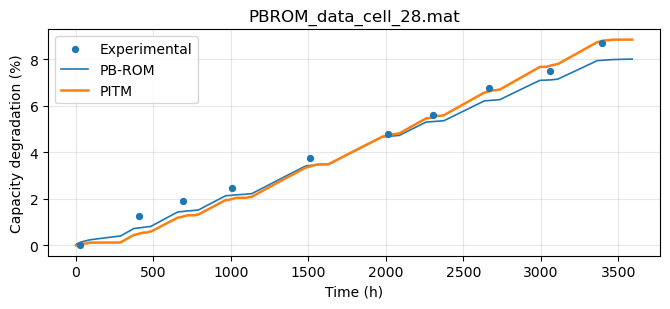

Evaluating test cells:  50%|████████████████                | 1/2 [00:04<00:04,  4.62s/it]

Saved -> plots/PBROM_data_cell_28_pred_pct_BEST_RANDOM_SEARCH_MODEL.png


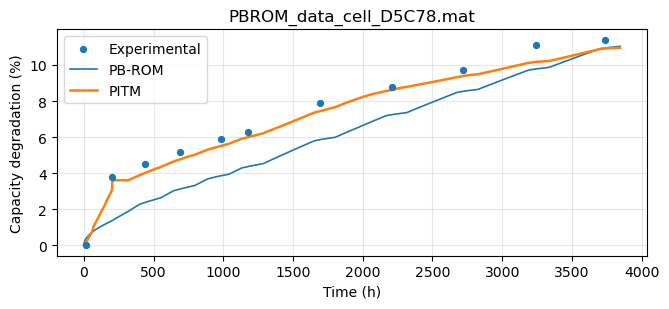

Evaluating test cells: 100%|████████████████████████████████| 2/2 [00:24<00:00, 12.25s/it]

Saved -> plots/PBROM_data_cell_D5C78_pred_pct_BEST_RANDOM_SEARCH_MODEL.png

📊 PITM Testing Results (per cell)
  PBROM_data_cell_28.mat                 [PITM] MSE=6.975e-09 RSEP=7.48% MAPE=14.65%     
  PBROM_data_cell_D5C78.mat              [PITM] MSE=2.427e-05 RSEP=6.54% MAPE=7.32%     

Per-Cell Evaluation Complete.
Average RSEP: 7.0142%


In [74]:
# ==========================================================
# Cell 11 — Load Best Model from Random Search & Evaluate
# ==========================================================
import os
import tensorflow as tf
import numpy as np
import pandas as pd

RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Random search results not found at: {RESULTS_CSV}")

df_results = pd.read_csv(RESULTS_CSV)

# Sort by avg_rsep_pitm ascending (lower is better)
df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)
best_row = df_sorted.iloc[0]

print("🏆  Best model found from Random Search (Stage 2)")
print(best_row)

BEST_RUN_NUM   = int(best_row["run_num"])
BEST_WS        = int(best_row["window_size"])
BEST_LAYERS    = int(best_row["num_layers"])
BEST_EMBED     = int(best_row["embed_dim"])
BEST_LAMBDA_PHYS = float(best_row["lambda_phys"])

# Rebuild the model architecture with these hyperparameters
print(f"\nRebuilding best model from random search:")
print(f"  Run number:   {BEST_RUN_NUM}")
print(f"  Window Size:  {BEST_WS}")
print(f"  Num Layers:   {BEST_LAYERS}")
print(f"  Embed Dim:    {BEST_EMBED}")
print(f"  lambda_phys:  {BEST_LAMBDA_PHYS:.4f}")

tf.keras.backend.clear_session()

model = build_pitm_model(
    window_size=BEST_WS,
    num_groups=NUM_GROUPS,
    embed_dim=BEST_EMBED,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=BEST_LAYERS,
    dropout=DROPOUT
)

# Load the best checkpoint from that run
run_name = f"rs2_run{BEST_RUN_NUM}"
CHECKPOINT_NAME = f"{run_name}_best.h5"
MODEL_TO_TEST = os.path.join("checkpoints", CHECKPOINT_NAME)

if not os.path.exists(MODEL_TO_TEST):
    raise FileNotFoundError(f"Checkpoint not found: {MODEL_TO_TEST}")
else:
    model.load_weights(MODEL_TO_TEST)
    print(f"\n✅ Successfully loaded weights from: {MODEL_TO_TEST}")

# Run full evaluation on TEST cells with plots
print("\nRunning final evaluation on all TEST cells...")
results = evaluate_model_on_test(
    model,
    window_size=BEST_WS,
    stride=STRIDE,
    plot_suffix="BEST_RANDOM_SEARCH_MODEL",
    do_plot=True
)

rsep_values = [res[3] for res in results if np.isfinite(res[3])]
final_avg_rsep = np.mean(rsep_values) if rsep_values else np.nan

print("\n" + "="*50)
print(f"Per-Cell Evaluation Complete.")
print(f"Average RSEP: {final_avg_rsep:.4f}%")
print("="*50)


In [75]:
# ==========================================================
# Cell 12 — Save per-cell curves for external plotting (corrected)
# ==========================================================
import os
import numpy as np

SAVE_DIR = "saved_curves"
os.makedirs(SAVE_DIR, exist_ok=True)

for fn in TEST_FILES:
    base = os.path.splitext(os.path.basename(fn))[0]
    group_label = FILE_TO_GROUP_MAP.get(fn, "UnknownGroup")
    print(f"\nExtracting curves for {base} (group: {group_label}) ...")

    out = predict_cell(
        model,
        file_name=fn,
        window_size=BEST_WS,
        stride=STRIDE,
    )

    if out is None or len(out) < 7:
        print(f"  ⚠ Skipping {base}: invalid predict_cell output")
        continue

    t_dense, q_exp_norm_d, q_pb_norm_d, q_hat_norm_d, cap_nom, Time_s_full, t_exp = out

    if t_dense.size == 0:
        print(f"  ⚠ Skipping {base}: no windows produced.")
        continue

    # ---- ALIGN EXPERIMENTAL (sparse) TO MODEL (dense) ----
    # Restrict experimental timestamps to dense coverage
    t_exp_use = t_exp[(t_exp >= t_dense[0]) & (t_exp <= t_dense[-1])]
    if t_exp_use.size == 0:
        print(f"  ⚠ No experimental times within model window for {fn}.")
        continue

    # Nearest indices
    idx = nearest_indices(t_dense, t_exp_use)
    if idx.size == 0:
        print(f"  ⚠ nearest_indices returned empty for {fn}.")
        continue

    # Sparse experimental curves (correct!)
    q_exp_norm_sparse = q_exp_norm_d[idx]

    # Dense curves
    t_dense_hours = t_dense / 3600.0
    q_pb_pct_dense  = 100.0 * q_pb_norm_d
    q_hat_pct_dense = 100.0 * q_hat_norm_d

    # Sparse curves
    t_exp_hours = t_exp_use / 3600.0
    q_exp_pct_sparse = 100.0 * q_exp_norm_sparse

    # ---- SAVE CONSISTENT FORMAT (same as single-group saving) ----
    out_name = f"{group_label}_{base}_BEST_MODEL_CURVES.npz"
    out_path = os.path.join(SAVE_DIR, out_name)

    np.savez_compressed(
        out_path,
        # sparse
        t_exp=t_exp_hours,
        q_exp_pct=q_exp_pct_sparse,

        # dense
        t_dense=t_dense_hours,
        q_pb_pct=q_pb_pct_dense,
        q_hat_pct=q_hat_pct_dense,

        # metadata
        group_label=group_label,
        file_name=fn,
        cap_nom=cap_nom,
        window_size=BEST_WS,
        stride=STRIDE,
    )

    print(f"  ✓ Saved → {out_path}")

print("\n✅ Cell 12 complete: multi-group curves exported in consistent format.")



Extracting curves for PBROM_data_cell_28 (group: PBROM_Cells_1) ...
  ✓ Saved → saved_curves/PBROM_Cells_1_PBROM_data_cell_28_BEST_MODEL_CURVES.npz

Extracting curves for PBROM_data_cell_D5C78 (group: D5_Cells_1) ...
  ✓ Saved → saved_curves/D5_Cells_1_PBROM_data_cell_D5C78_BEST_MODEL_CURVES.npz

✅ Cell 12 complete: multi-group curves exported in consistent format.
